In [1]:
# Install libs
!pip install -q datasets torchcfm

# Dataset
from datasets import load_dataset

ds = load_dataset("wanhin/naruto-captions", split="train")

# Text Encoder:
import torch
from sentence_transformers import SentenceTransformer

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
text_encoder = SentenceTransformer("all-mpnet-base-v2").to(device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is

README.md:   0%|          | 0.00/321 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/344M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/357M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1221 [00:00<?, ? examples/s]

2025-04-13 03:41:52.718443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744515713.008747      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744515713.076555      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [2]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

from torch.utils.data import Dataset, DataLoader

class CFMDataset(Dataset):
    def __init__(self, dataset, transform, text_encoder, device):
        self.dataset = dataset
        self.transform = transform
        self.text_encoder = text_encoder
        self.device = device
        self.images = dataset["image"]
        self.captions = dataset["text"]
        self.embed_captions = text_encoder.encode(
            self.captions, convert_to_tensor=True, device=self.device
        )

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # get an image
        image = self.images[idx]
        image = self.transform(image)

        # get a text
        caption = self.captions[idx]
        caption_embedding = self.embed_captions[idx]

        return {
            "image": image,
            "caption": caption,
            "caption_embedding": caption_embedding,
        }

train_ds = CFMDataset(ds, transform, text_encoder, device)
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)


Batches:   0%|          | 0/39 [00:00<?, ?it/s]

In [3]:
import math
import torch.nn as nn
from torchcfm.models.unet import UNetModel

def timestep_embedding(timesteps, dim, max_period=10000):
    """Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element. These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period)
        * torch.arange(start=0, end=half, dtype=torch.float32, device=timesteps.device)
        / half
    )
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

class UNetModelWithTextEmbedding(UNetModel):
    def __init__(self, dim, num_channels, num_res_blocks, embedding_dim, *args, **kwargs):
        super().__init__(dim, num_channels, num_res_blocks, *args, **kwargs)

        self.embedding_layer = nn.Linear(embedding_dim, num_channels * 4)
        self.fc = nn.Linear(num_channels * 8, num_channels * 4)

    def forward(self, t, x, text_embeddings=None):
        """Apply the model to an input batch, incorporating text embeddings."""
        timesteps = t

        while timesteps.dim() > 1:
            timesteps = timesteps[:, 0]
        if timesteps.dim() == 0:
            timesteps = timesteps.repeat(x.shape[0])

        hs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        if text_embeddings is not None:
            text_embedded = self.embedding_layer(text_embeddings)
            emb = torch.cat([emb, text_embedded], dim=1)  # 128*2
            emb = self.fc(emb)

        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)
        h = self.middle_block(h, emb)
        for module in self.output_blocks:
            h = torch.cat([h, hs.pop()], dim=1)
            h = module(h, emb)
        h = h.type(x.dtype)
        return self.out(h)


In [4]:
from tqdm import tqdm
import torch

model = UNetModelWithTextEmbedding(
    dim=(3, 64, 64), num_channels=32, num_res_blocks=1, embedding_dim=768
).to(device)
optimizer = torch.optim.Adam(model.parameters())

n_epochs = 1000
best_loss = float("inf")  # Khởi tạo loss tốt nhất rất lớn
save_path = "/kaggle/working/best_model.pth"  # Đường dẫn lưu model

for epoch in tqdm(range(n_epochs)):
    losses = []
    for batch in train_loader:
        optimizer.zero_grad()
        x1 = batch["image"].to(device)
        text_embeddings = batch["caption_embedding"].to(device)
        x0 = torch.randn_like(x1).to(device)
        t = torch.rand(x0.shape[0], 1, 1, 1).to(device)
        xt = t * x1 + (1 - t) * x0
        ut = x1 - x0
        t = t.squeeze()
        vt = model(t, xt, text_embeddings=text_embeddings)
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {avg_loss:.4f}")

    # Lưu model nếu tốt hơn best_loss trước đó
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), save_path)
        print(f"✅ Saved new best model with loss {best_loss:.4f} to '{save_path}'")


  0%|          | 1/1000 [00:09<2:43:25,  9.82s/it]

Epoch [1/1000], Loss: 1.1637
✅ Saved new best model with loss 1.1637 to '/kaggle/working/best_model.pth'


  0%|          | 2/1000 [00:18<2:35:49,  9.37s/it]

Epoch [2/1000], Loss: 0.9048
✅ Saved new best model with loss 0.9048 to '/kaggle/working/best_model.pth'


  0%|          | 3/1000 [00:27<2:33:01,  9.21s/it]

Epoch [3/1000], Loss: 0.7192
✅ Saved new best model with loss 0.7192 to '/kaggle/working/best_model.pth'


  0%|          | 4/1000 [00:36<2:32:08,  9.17s/it]

Epoch [4/1000], Loss: 0.5941
✅ Saved new best model with loss 0.5941 to '/kaggle/working/best_model.pth'


  0%|          | 5/1000 [00:46<2:31:57,  9.16s/it]

Epoch [5/1000], Loss: 0.4996
✅ Saved new best model with loss 0.4996 to '/kaggle/working/best_model.pth'


  1%|          | 6/1000 [00:55<2:32:09,  9.18s/it]

Epoch [6/1000], Loss: 0.4090
✅ Saved new best model with loss 0.4090 to '/kaggle/working/best_model.pth'


  1%|          | 7/1000 [01:04<2:31:48,  9.17s/it]

Epoch [7/1000], Loss: 0.3399
✅ Saved new best model with loss 0.3399 to '/kaggle/working/best_model.pth'


  1%|          | 8/1000 [01:13<2:31:35,  9.17s/it]

Epoch [8/1000], Loss: 0.2774
✅ Saved new best model with loss 0.2774 to '/kaggle/working/best_model.pth'


  1%|          | 9/1000 [01:23<2:32:15,  9.22s/it]

Epoch [9/1000], Loss: 0.2428
✅ Saved new best model with loss 0.2428 to '/kaggle/working/best_model.pth'


  1%|          | 10/1000 [01:32<2:32:44,  9.26s/it]

Epoch [10/1000], Loss: 0.2090
✅ Saved new best model with loss 0.2090 to '/kaggle/working/best_model.pth'


  1%|          | 11/1000 [01:41<2:32:57,  9.28s/it]

Epoch [11/1000], Loss: 0.1867
✅ Saved new best model with loss 0.1867 to '/kaggle/working/best_model.pth'


  1%|          | 12/1000 [01:51<2:33:52,  9.34s/it]

Epoch [12/1000], Loss: 0.1692
✅ Saved new best model with loss 0.1692 to '/kaggle/working/best_model.pth'


  1%|▏         | 13/1000 [02:00<2:34:23,  9.39s/it]

Epoch [13/1000], Loss: 0.1610
✅ Saved new best model with loss 0.1610 to '/kaggle/working/best_model.pth'


  1%|▏         | 14/1000 [02:10<2:35:00,  9.43s/it]

Epoch [14/1000], Loss: 0.1516
✅ Saved new best model with loss 0.1516 to '/kaggle/working/best_model.pth'


  2%|▏         | 15/1000 [02:19<2:36:08,  9.51s/it]

Epoch [15/1000], Loss: 0.1513
✅ Saved new best model with loss 0.1513 to '/kaggle/working/best_model.pth'


  2%|▏         | 16/1000 [02:29<2:37:10,  9.58s/it]

Epoch [16/1000], Loss: 0.1462
✅ Saved new best model with loss 0.1462 to '/kaggle/working/best_model.pth'


  2%|▏         | 17/1000 [02:39<2:38:37,  9.68s/it]

Epoch [17/1000], Loss: 0.1484


  2%|▏         | 18/1000 [02:49<2:39:51,  9.77s/it]

Epoch [18/1000], Loss: 0.1422
✅ Saved new best model with loss 0.1422 to '/kaggle/working/best_model.pth'


  2%|▏         | 19/1000 [02:59<2:39:51,  9.78s/it]

Epoch [19/1000], Loss: 0.1427


  2%|▏         | 20/1000 [03:09<2:39:26,  9.76s/it]

Epoch [20/1000], Loss: 0.1326
✅ Saved new best model with loss 0.1326 to '/kaggle/working/best_model.pth'


  2%|▏         | 21/1000 [03:18<2:38:11,  9.70s/it]

Epoch [21/1000], Loss: 0.1359


  2%|▏         | 22/1000 [03:28<2:37:58,  9.69s/it]

Epoch [22/1000], Loss: 0.1301
✅ Saved new best model with loss 0.1301 to '/kaggle/working/best_model.pth'


  2%|▏         | 23/1000 [03:37<2:37:22,  9.67s/it]

Epoch [23/1000], Loss: 0.1329


  2%|▏         | 24/1000 [03:47<2:37:18,  9.67s/it]

Epoch [24/1000], Loss: 0.1233
✅ Saved new best model with loss 0.1233 to '/kaggle/working/best_model.pth'


  2%|▎         | 25/1000 [03:57<2:37:57,  9.72s/it]

Epoch [25/1000], Loss: 0.1220
✅ Saved new best model with loss 0.1220 to '/kaggle/working/best_model.pth'


  3%|▎         | 26/1000 [04:07<2:37:38,  9.71s/it]

Epoch [26/1000], Loss: 0.1252


  3%|▎         | 27/1000 [04:16<2:37:29,  9.71s/it]

Epoch [27/1000], Loss: 0.1242


  3%|▎         | 28/1000 [04:26<2:37:31,  9.72s/it]

Epoch [28/1000], Loss: 0.1303


  3%|▎         | 29/1000 [04:36<2:37:00,  9.70s/it]

Epoch [29/1000], Loss: 0.1231


  3%|▎         | 30/1000 [04:45<2:36:55,  9.71s/it]

Epoch [30/1000], Loss: 0.1139
✅ Saved new best model with loss 0.1139 to '/kaggle/working/best_model.pth'


  3%|▎         | 31/1000 [04:55<2:36:44,  9.71s/it]

Epoch [31/1000], Loss: 0.1145


  3%|▎         | 32/1000 [05:05<2:36:13,  9.68s/it]

Epoch [32/1000], Loss: 0.1140


  3%|▎         | 33/1000 [05:14<2:35:30,  9.65s/it]

Epoch [33/1000], Loss: 0.1160


  3%|▎         | 34/1000 [05:24<2:35:30,  9.66s/it]

Epoch [34/1000], Loss: 0.1202


  4%|▎         | 35/1000 [05:34<2:35:22,  9.66s/it]

Epoch [35/1000], Loss: 0.1167


  4%|▎         | 36/1000 [05:43<2:35:33,  9.68s/it]

Epoch [36/1000], Loss: 0.1069
✅ Saved new best model with loss 0.1069 to '/kaggle/working/best_model.pth'


  4%|▎         | 37/1000 [05:53<2:35:07,  9.66s/it]

Epoch [37/1000], Loss: 0.1073


  4%|▍         | 38/1000 [06:03<2:35:13,  9.68s/it]

Epoch [38/1000], Loss: 0.1107


  4%|▍         | 39/1000 [06:12<2:34:44,  9.66s/it]

Epoch [39/1000], Loss: 0.1098


  4%|▍         | 40/1000 [06:22<2:34:36,  9.66s/it]

Epoch [40/1000], Loss: 0.1055
✅ Saved new best model with loss 0.1055 to '/kaggle/working/best_model.pth'


  4%|▍         | 41/1000 [06:32<2:34:37,  9.67s/it]

Epoch [41/1000], Loss: 0.1126


  4%|▍         | 42/1000 [06:41<2:34:16,  9.66s/it]

Epoch [42/1000], Loss: 0.1077


  4%|▍         | 43/1000 [06:51<2:34:05,  9.66s/it]

Epoch [43/1000], Loss: 0.1057


  4%|▍         | 44/1000 [07:01<2:34:06,  9.67s/it]

Epoch [44/1000], Loss: 0.1027
✅ Saved new best model with loss 0.1027 to '/kaggle/working/best_model.pth'


  4%|▍         | 45/1000 [07:10<2:34:04,  9.68s/it]

Epoch [45/1000], Loss: 0.0977
✅ Saved new best model with loss 0.0977 to '/kaggle/working/best_model.pth'


  5%|▍         | 46/1000 [07:20<2:33:45,  9.67s/it]

Epoch [46/1000], Loss: 0.1035


  5%|▍         | 47/1000 [07:30<2:33:29,  9.66s/it]

Epoch [47/1000], Loss: 0.1030


  5%|▍         | 48/1000 [07:39<2:33:27,  9.67s/it]

Epoch [48/1000], Loss: 0.1003


  5%|▍         | 49/1000 [07:49<2:33:23,  9.68s/it]

Epoch [49/1000], Loss: 0.0956
✅ Saved new best model with loss 0.0956 to '/kaggle/working/best_model.pth'


  5%|▌         | 50/1000 [07:59<2:33:05,  9.67s/it]

Epoch [50/1000], Loss: 0.0985


  5%|▌         | 51/1000 [08:08<2:33:01,  9.68s/it]

Epoch [51/1000], Loss: 0.1000


  5%|▌         | 52/1000 [08:18<2:32:43,  9.67s/it]

Epoch [52/1000], Loss: 0.1016


  5%|▌         | 53/1000 [08:28<2:32:28,  9.66s/it]

Epoch [53/1000], Loss: 0.0956


  5%|▌         | 54/1000 [08:37<2:32:44,  9.69s/it]

Epoch [54/1000], Loss: 0.0962


  6%|▌         | 55/1000 [08:47<2:32:55,  9.71s/it]

Epoch [55/1000], Loss: 0.0917
✅ Saved new best model with loss 0.0917 to '/kaggle/working/best_model.pth'


  6%|▌         | 56/1000 [08:57<2:32:47,  9.71s/it]

Epoch [56/1000], Loss: 0.0953


  6%|▌         | 57/1000 [09:07<2:32:40,  9.71s/it]

Epoch [57/1000], Loss: 0.0910
✅ Saved new best model with loss 0.0910 to '/kaggle/working/best_model.pth'


  6%|▌         | 58/1000 [09:16<2:32:23,  9.71s/it]

Epoch [58/1000], Loss: 0.0946


  6%|▌         | 59/1000 [09:26<2:31:45,  9.68s/it]

Epoch [59/1000], Loss: 0.0939


  6%|▌         | 60/1000 [09:36<2:31:29,  9.67s/it]

Epoch [60/1000], Loss: 0.0972


  6%|▌         | 61/1000 [09:45<2:31:39,  9.69s/it]

Epoch [61/1000], Loss: 0.0915


  6%|▌         | 62/1000 [09:55<2:31:29,  9.69s/it]

Epoch [62/1000], Loss: 0.0955


  6%|▋         | 63/1000 [10:05<2:31:35,  9.71s/it]

Epoch [63/1000], Loss: 0.0889
✅ Saved new best model with loss 0.0889 to '/kaggle/working/best_model.pth'


  6%|▋         | 64/1000 [10:15<2:31:52,  9.74s/it]

Epoch [64/1000], Loss: 0.0951


  6%|▋         | 65/1000 [10:24<2:31:31,  9.72s/it]

Epoch [65/1000], Loss: 0.0865
✅ Saved new best model with loss 0.0865 to '/kaggle/working/best_model.pth'


  7%|▋         | 66/1000 [10:34<2:31:06,  9.71s/it]

Epoch [66/1000], Loss: 0.0935


  7%|▋         | 67/1000 [10:44<2:31:10,  9.72s/it]

Epoch [67/1000], Loss: 0.0930


  7%|▋         | 68/1000 [10:53<2:30:38,  9.70s/it]

Epoch [68/1000], Loss: 0.0888


  7%|▋         | 69/1000 [11:03<2:30:29,  9.70s/it]

Epoch [69/1000], Loss: 0.0858
✅ Saved new best model with loss 0.0858 to '/kaggle/working/best_model.pth'


  7%|▋         | 70/1000 [11:13<2:30:28,  9.71s/it]

Epoch [70/1000], Loss: 0.0838
✅ Saved new best model with loss 0.0838 to '/kaggle/working/best_model.pth'


  7%|▋         | 71/1000 [11:23<2:30:21,  9.71s/it]

Epoch [71/1000], Loss: 0.0885


  7%|▋         | 72/1000 [11:32<2:30:13,  9.71s/it]

Epoch [72/1000], Loss: 0.0902


  7%|▋         | 73/1000 [11:42<2:30:06,  9.72s/it]

Epoch [73/1000], Loss: 0.0869


  7%|▋         | 74/1000 [11:52<2:30:30,  9.75s/it]

Epoch [74/1000], Loss: 0.0882


  8%|▊         | 75/1000 [12:02<2:30:16,  9.75s/it]

Epoch [75/1000], Loss: 0.0852


  8%|▊         | 76/1000 [12:11<2:30:00,  9.74s/it]

Epoch [76/1000], Loss: 0.0908


  8%|▊         | 77/1000 [12:21<2:29:50,  9.74s/it]

Epoch [77/1000], Loss: 0.0867


  8%|▊         | 78/1000 [12:31<2:29:18,  9.72s/it]

Epoch [78/1000], Loss: 0.0851


  8%|▊         | 79/1000 [12:40<2:28:57,  9.70s/it]

Epoch [79/1000], Loss: 0.0940


  8%|▊         | 80/1000 [12:50<2:29:03,  9.72s/it]

Epoch [80/1000], Loss: 0.0892


  8%|▊         | 81/1000 [13:00<2:28:54,  9.72s/it]

Epoch [81/1000], Loss: 0.0892


  8%|▊         | 82/1000 [13:10<2:28:54,  9.73s/it]

Epoch [82/1000], Loss: 0.0861


  8%|▊         | 83/1000 [13:19<2:28:38,  9.73s/it]

Epoch [83/1000], Loss: 0.0905


  8%|▊         | 84/1000 [13:29<2:28:40,  9.74s/it]

Epoch [84/1000], Loss: 0.0853


  8%|▊         | 85/1000 [13:39<2:28:13,  9.72s/it]

Epoch [85/1000], Loss: 0.0884


  9%|▊         | 86/1000 [13:48<2:27:54,  9.71s/it]

Epoch [86/1000], Loss: 0.0874


  9%|▊         | 87/1000 [13:58<2:27:39,  9.70s/it]

Epoch [87/1000], Loss: 0.0874


  9%|▉         | 88/1000 [14:08<2:27:18,  9.69s/it]

Epoch [88/1000], Loss: 0.0886


  9%|▉         | 89/1000 [14:17<2:26:55,  9.68s/it]

Epoch [89/1000], Loss: 0.0891


  9%|▉         | 90/1000 [14:27<2:26:59,  9.69s/it]

Epoch [90/1000], Loss: 0.0889


  9%|▉         | 91/1000 [14:37<2:26:34,  9.68s/it]

Epoch [91/1000], Loss: 0.0858


  9%|▉         | 92/1000 [14:46<2:26:18,  9.67s/it]

Epoch [92/1000], Loss: 0.0871


  9%|▉         | 93/1000 [14:56<2:26:20,  9.68s/it]

Epoch [93/1000], Loss: 0.0857


  9%|▉         | 94/1000 [15:06<2:26:31,  9.70s/it]

Epoch [94/1000], Loss: 0.0821
✅ Saved new best model with loss 0.0821 to '/kaggle/working/best_model.pth'


 10%|▉         | 95/1000 [15:16<2:26:45,  9.73s/it]

Epoch [95/1000], Loss: 0.0815
✅ Saved new best model with loss 0.0815 to '/kaggle/working/best_model.pth'


 10%|▉         | 96/1000 [15:25<2:26:45,  9.74s/it]

Epoch [96/1000], Loss: 0.0850


 10%|▉         | 97/1000 [15:36<2:28:31,  9.87s/it]

Epoch [97/1000], Loss: 0.0849


 10%|▉         | 98/1000 [15:45<2:27:28,  9.81s/it]

Epoch [98/1000], Loss: 0.0844


 10%|▉         | 99/1000 [15:55<2:26:42,  9.77s/it]

Epoch [99/1000], Loss: 0.0846


 10%|█         | 100/1000 [16:05<2:26:05,  9.74s/it]

Epoch [100/1000], Loss: 0.0846


 10%|█         | 101/1000 [16:14<2:25:56,  9.74s/it]

Epoch [101/1000], Loss: 0.0789
✅ Saved new best model with loss 0.0789 to '/kaggle/working/best_model.pth'


 10%|█         | 102/1000 [16:24<2:25:41,  9.73s/it]

Epoch [102/1000], Loss: 0.0783
✅ Saved new best model with loss 0.0783 to '/kaggle/working/best_model.pth'


 10%|█         | 103/1000 [16:34<2:25:49,  9.75s/it]

Epoch [103/1000], Loss: 0.0785


 10%|█         | 104/1000 [16:44<2:25:12,  9.72s/it]

Epoch [104/1000], Loss: 0.0847


 10%|█         | 105/1000 [16:53<2:24:48,  9.71s/it]

Epoch [105/1000], Loss: 0.0802


 11%|█         | 106/1000 [17:03<2:24:41,  9.71s/it]

Epoch [106/1000], Loss: 0.0775
✅ Saved new best model with loss 0.0775 to '/kaggle/working/best_model.pth'


 11%|█         | 107/1000 [17:13<2:24:17,  9.70s/it]

Epoch [107/1000], Loss: 0.0827


 11%|█         | 108/1000 [17:22<2:23:52,  9.68s/it]

Epoch [108/1000], Loss: 0.0834


 11%|█         | 109/1000 [17:32<2:23:51,  9.69s/it]

Epoch [109/1000], Loss: 0.0845


 11%|█         | 110/1000 [17:42<2:23:29,  9.67s/it]

Epoch [110/1000], Loss: 0.0842


 11%|█         | 111/1000 [17:51<2:23:19,  9.67s/it]

Epoch [111/1000], Loss: 0.0832


 11%|█         | 112/1000 [18:01<2:23:03,  9.67s/it]

Epoch [112/1000], Loss: 0.0818


 11%|█▏        | 113/1000 [18:11<2:23:04,  9.68s/it]

Epoch [113/1000], Loss: 0.0820


 11%|█▏        | 114/1000 [18:20<2:22:49,  9.67s/it]

Epoch [114/1000], Loss: 0.0793


 12%|█▏        | 115/1000 [18:30<2:22:41,  9.67s/it]

Epoch [115/1000], Loss: 0.0784


 12%|█▏        | 116/1000 [18:40<2:22:28,  9.67s/it]

Epoch [116/1000], Loss: 0.0819


 12%|█▏        | 117/1000 [18:49<2:22:06,  9.66s/it]

Epoch [117/1000], Loss: 0.0799


 12%|█▏        | 118/1000 [18:59<2:21:55,  9.65s/it]

Epoch [118/1000], Loss: 0.0817


 12%|█▏        | 119/1000 [19:09<2:21:58,  9.67s/it]

Epoch [119/1000], Loss: 0.0815


 12%|█▏        | 120/1000 [19:18<2:21:35,  9.65s/it]

Epoch [120/1000], Loss: 0.0799


 12%|█▏        | 121/1000 [19:28<2:21:25,  9.65s/it]

Epoch [121/1000], Loss: 0.0777


 12%|█▏        | 122/1000 [19:38<2:21:22,  9.66s/it]

Epoch [122/1000], Loss: 0.0802


 12%|█▏        | 123/1000 [19:47<2:21:33,  9.68s/it]

Epoch [123/1000], Loss: 0.0758
✅ Saved new best model with loss 0.0758 to '/kaggle/working/best_model.pth'


 12%|█▏        | 124/1000 [19:57<2:21:23,  9.68s/it]

Epoch [124/1000], Loss: 0.0818


 12%|█▎        | 125/1000 [20:07<2:21:03,  9.67s/it]

Epoch [125/1000], Loss: 0.0806


 13%|█▎        | 126/1000 [20:16<2:20:43,  9.66s/it]

Epoch [126/1000], Loss: 0.0749
✅ Saved new best model with loss 0.0749 to '/kaggle/working/best_model.pth'


 13%|█▎        | 127/1000 [20:26<2:20:21,  9.65s/it]

Epoch [127/1000], Loss: 0.0779


 13%|█▎        | 128/1000 [20:36<2:20:16,  9.65s/it]

Epoch [128/1000], Loss: 0.0792


 13%|█▎        | 129/1000 [20:45<2:20:21,  9.67s/it]

Epoch [129/1000], Loss: 0.0774


 13%|█▎        | 130/1000 [20:55<2:20:22,  9.68s/it]

Epoch [130/1000], Loss: 0.0788


 13%|█▎        | 131/1000 [21:05<2:20:04,  9.67s/it]

Epoch [131/1000], Loss: 0.0766


 13%|█▎        | 132/1000 [21:14<2:20:01,  9.68s/it]

Epoch [132/1000], Loss: 0.0806


 13%|█▎        | 133/1000 [21:24<2:19:40,  9.67s/it]

Epoch [133/1000], Loss: 0.0792


 13%|█▎        | 134/1000 [21:34<2:19:18,  9.65s/it]

Epoch [134/1000], Loss: 0.0760


 14%|█▎        | 135/1000 [21:43<2:19:02,  9.64s/it]

Epoch [135/1000], Loss: 0.0768


 14%|█▎        | 136/1000 [21:53<2:19:06,  9.66s/it]

Epoch [136/1000], Loss: 0.0798


 14%|█▎        | 137/1000 [22:02<2:18:46,  9.65s/it]

Epoch [137/1000], Loss: 0.0767


 14%|█▍        | 138/1000 [22:12<2:18:28,  9.64s/it]

Epoch [138/1000], Loss: 0.0784


 14%|█▍        | 139/1000 [22:22<2:18:53,  9.68s/it]

Epoch [139/1000], Loss: 0.0781


 14%|█▍        | 140/1000 [22:32<2:18:35,  9.67s/it]

Epoch [140/1000], Loss: 0.0782


 14%|█▍        | 141/1000 [22:41<2:18:32,  9.68s/it]

Epoch [141/1000], Loss: 0.0747
✅ Saved new best model with loss 0.0747 to '/kaggle/working/best_model.pth'


 14%|█▍        | 142/1000 [22:51<2:18:18,  9.67s/it]

Epoch [142/1000], Loss: 0.0766


 14%|█▍        | 143/1000 [23:00<2:18:00,  9.66s/it]

Epoch [143/1000], Loss: 0.0770


 14%|█▍        | 144/1000 [23:10<2:17:41,  9.65s/it]

Epoch [144/1000], Loss: 0.0776


 14%|█▍        | 145/1000 [23:20<2:17:29,  9.65s/it]

Epoch [145/1000], Loss: 0.0780


 15%|█▍        | 146/1000 [23:29<2:17:07,  9.63s/it]

Epoch [146/1000], Loss: 0.0797


 15%|█▍        | 147/1000 [23:39<2:16:54,  9.63s/it]

Epoch [147/1000], Loss: 0.0799


 15%|█▍        | 148/1000 [23:49<2:16:44,  9.63s/it]

Epoch [148/1000], Loss: 0.0774


 15%|█▍        | 149/1000 [23:58<2:16:51,  9.65s/it]

Epoch [149/1000], Loss: 0.0776


 15%|█▌        | 150/1000 [24:08<2:16:43,  9.65s/it]

Epoch [150/1000], Loss: 0.0753


 15%|█▌        | 151/1000 [24:18<2:16:50,  9.67s/it]

Epoch [151/1000], Loss: 0.0720
✅ Saved new best model with loss 0.0720 to '/kaggle/working/best_model.pth'


 15%|█▌        | 152/1000 [24:27<2:16:38,  9.67s/it]

Epoch [152/1000], Loss: 0.0761


 15%|█▌        | 153/1000 [24:37<2:16:34,  9.67s/it]

Epoch [153/1000], Loss: 0.0782


 15%|█▌        | 154/1000 [24:47<2:16:05,  9.65s/it]

Epoch [154/1000], Loss: 0.0725


 16%|█▌        | 155/1000 [24:56<2:15:57,  9.65s/it]

Epoch [155/1000], Loss: 0.0781


 16%|█▌        | 156/1000 [25:06<2:15:35,  9.64s/it]

Epoch [156/1000], Loss: 0.0739


 16%|█▌        | 157/1000 [25:16<2:15:22,  9.64s/it]

Epoch [157/1000], Loss: 0.0741


 16%|█▌        | 158/1000 [25:25<2:15:24,  9.65s/it]

Epoch [158/1000], Loss: 0.0758


 16%|█▌        | 159/1000 [25:35<2:15:14,  9.65s/it]

Epoch [159/1000], Loss: 0.0749


 16%|█▌        | 160/1000 [25:44<2:14:58,  9.64s/it]

Epoch [160/1000], Loss: 0.0758


 16%|█▌        | 161/1000 [25:54<2:14:53,  9.65s/it]

Epoch [161/1000], Loss: 0.0744


 16%|█▌        | 162/1000 [26:04<2:14:58,  9.66s/it]

Epoch [162/1000], Loss: 0.0764


 16%|█▋        | 163/1000 [26:14<2:15:03,  9.68s/it]

Epoch [163/1000], Loss: 0.0734


 16%|█▋        | 164/1000 [26:23<2:14:49,  9.68s/it]

Epoch [164/1000], Loss: 0.0771


 16%|█▋        | 165/1000 [26:33<2:14:38,  9.67s/it]

Epoch [165/1000], Loss: 0.0736


 17%|█▋        | 166/1000 [26:43<2:14:13,  9.66s/it]

Epoch [166/1000], Loss: 0.0733


 17%|█▋        | 167/1000 [26:52<2:14:01,  9.65s/it]

Epoch [167/1000], Loss: 0.0729


 17%|█▋        | 168/1000 [27:02<2:13:50,  9.65s/it]

Epoch [168/1000], Loss: 0.0727


 17%|█▋        | 169/1000 [27:11<2:13:43,  9.66s/it]

Epoch [169/1000], Loss: 0.0805


 17%|█▋        | 170/1000 [27:21<2:13:39,  9.66s/it]

Epoch [170/1000], Loss: 0.0757


 17%|█▋        | 171/1000 [27:31<2:13:40,  9.68s/it]

Epoch [171/1000], Loss: 0.0753


 17%|█▋        | 172/1000 [27:41<2:13:40,  9.69s/it]

Epoch [172/1000], Loss: 0.0707
✅ Saved new best model with loss 0.0707 to '/kaggle/working/best_model.pth'


 17%|█▋        | 173/1000 [27:50<2:13:11,  9.66s/it]

Epoch [173/1000], Loss: 0.0752


 17%|█▋        | 174/1000 [28:00<2:12:35,  9.63s/it]

Epoch [174/1000], Loss: 0.0729


 18%|█▊        | 175/1000 [28:09<2:12:27,  9.63s/it]

Epoch [175/1000], Loss: 0.0696
✅ Saved new best model with loss 0.0696 to '/kaggle/working/best_model.pth'


 18%|█▊        | 176/1000 [28:19<2:12:10,  9.62s/it]

Epoch [176/1000], Loss: 0.0756


 18%|█▊        | 177/1000 [28:29<2:12:04,  9.63s/it]

Epoch [177/1000], Loss: 0.0725


 18%|█▊        | 178/1000 [28:38<2:12:31,  9.67s/it]

Epoch [178/1000], Loss: 0.0773


 18%|█▊        | 179/1000 [28:48<2:12:05,  9.65s/it]

Epoch [179/1000], Loss: 0.0732


 18%|█▊        | 180/1000 [28:58<2:11:56,  9.65s/it]

Epoch [180/1000], Loss: 0.0764


 18%|█▊        | 181/1000 [29:07<2:11:59,  9.67s/it]

Epoch [181/1000], Loss: 0.0762


 18%|█▊        | 182/1000 [29:17<2:11:37,  9.66s/it]

Epoch [182/1000], Loss: 0.0730


 18%|█▊        | 183/1000 [29:27<2:11:18,  9.64s/it]

Epoch [183/1000], Loss: 0.0791


 18%|█▊        | 184/1000 [29:36<2:11:02,  9.64s/it]

Epoch [184/1000], Loss: 0.0738


 18%|█▊        | 185/1000 [29:46<2:10:45,  9.63s/it]

Epoch [185/1000], Loss: 0.0713


 19%|█▊        | 186/1000 [29:55<2:10:40,  9.63s/it]

Epoch [186/1000], Loss: 0.0731


 19%|█▊        | 187/1000 [30:05<2:10:33,  9.64s/it]

Epoch [187/1000], Loss: 0.0737


 19%|█▉        | 188/1000 [30:15<2:10:38,  9.65s/it]

Epoch [188/1000], Loss: 0.0749


 19%|█▉        | 189/1000 [30:24<2:10:14,  9.64s/it]

Epoch [189/1000], Loss: 0.0769


 19%|█▉        | 190/1000 [30:34<2:10:04,  9.63s/it]

Epoch [190/1000], Loss: 0.0711


 19%|█▉        | 191/1000 [30:44<2:09:52,  9.63s/it]

Epoch [191/1000], Loss: 0.0763


 19%|█▉        | 192/1000 [30:53<2:09:54,  9.65s/it]

Epoch [192/1000], Loss: 0.0712


 19%|█▉        | 193/1000 [31:03<2:09:45,  9.65s/it]

Epoch [193/1000], Loss: 0.0711


 19%|█▉        | 194/1000 [31:13<2:09:37,  9.65s/it]

Epoch [194/1000], Loss: 0.0729


 20%|█▉        | 195/1000 [31:22<2:09:33,  9.66s/it]

Epoch [195/1000], Loss: 0.0732


 20%|█▉        | 196/1000 [31:32<2:09:29,  9.66s/it]

Epoch [196/1000], Loss: 0.0722


 20%|█▉        | 197/1000 [31:42<2:09:21,  9.67s/it]

Epoch [197/1000], Loss: 0.0746


 20%|█▉        | 198/1000 [31:51<2:09:17,  9.67s/it]

Epoch [198/1000], Loss: 0.0755


 20%|█▉        | 199/1000 [32:01<2:08:47,  9.65s/it]

Epoch [199/1000], Loss: 0.0717


 20%|██        | 200/1000 [32:11<2:08:29,  9.64s/it]

Epoch [200/1000], Loss: 0.0766


 20%|██        | 201/1000 [32:20<2:08:38,  9.66s/it]

Epoch [201/1000], Loss: 0.0723


 20%|██        | 202/1000 [32:30<2:08:23,  9.65s/it]

Epoch [202/1000], Loss: 0.0715


 20%|██        | 203/1000 [32:40<2:08:16,  9.66s/it]

Epoch [203/1000], Loss: 0.0726


 20%|██        | 204/1000 [32:49<2:08:02,  9.65s/it]

Epoch [204/1000], Loss: 0.0703


 20%|██        | 205/1000 [32:59<2:07:48,  9.65s/it]

Epoch [205/1000], Loss: 0.0720


 21%|██        | 206/1000 [33:08<2:07:35,  9.64s/it]

Epoch [206/1000], Loss: 0.0747


 21%|██        | 207/1000 [33:18<2:07:37,  9.66s/it]

Epoch [207/1000], Loss: 0.0703


 21%|██        | 208/1000 [33:28<2:07:09,  9.63s/it]

Epoch [208/1000], Loss: 0.0743


 21%|██        | 209/1000 [33:37<2:07:02,  9.64s/it]

Epoch [209/1000], Loss: 0.0732


 21%|██        | 210/1000 [33:47<2:07:05,  9.65s/it]

Epoch [210/1000], Loss: 0.0736


 21%|██        | 211/1000 [33:57<2:07:15,  9.68s/it]

Epoch [211/1000], Loss: 0.0729


 21%|██        | 212/1000 [34:06<2:07:01,  9.67s/it]

Epoch [212/1000], Loss: 0.0701


 21%|██▏       | 213/1000 [34:16<2:06:50,  9.67s/it]

Epoch [213/1000], Loss: 0.0682
✅ Saved new best model with loss 0.0682 to '/kaggle/working/best_model.pth'


 21%|██▏       | 214/1000 [34:26<2:06:24,  9.65s/it]

Epoch [214/1000], Loss: 0.0723


 22%|██▏       | 215/1000 [34:35<2:05:56,  9.63s/it]

Epoch [215/1000], Loss: 0.0728


 22%|██▏       | 216/1000 [34:45<2:05:35,  9.61s/it]

Epoch [216/1000], Loss: 0.0737


 22%|██▏       | 217/1000 [34:55<2:05:35,  9.62s/it]

Epoch [217/1000], Loss: 0.0706


 22%|██▏       | 218/1000 [35:04<2:05:38,  9.64s/it]

Epoch [218/1000], Loss: 0.0677
✅ Saved new best model with loss 0.0677 to '/kaggle/working/best_model.pth'


 22%|██▏       | 219/1000 [35:14<2:05:31,  9.64s/it]

Epoch [219/1000], Loss: 0.0710


 22%|██▏       | 220/1000 [35:24<2:05:29,  9.65s/it]

Epoch [220/1000], Loss: 0.0688


 22%|██▏       | 221/1000 [35:33<2:05:22,  9.66s/it]

Epoch [221/1000], Loss: 0.0699


 22%|██▏       | 222/1000 [35:43<2:05:15,  9.66s/it]

Epoch [222/1000], Loss: 0.0701


 22%|██▏       | 223/1000 [35:53<2:04:59,  9.65s/it]

Epoch [223/1000], Loss: 0.0709


 22%|██▏       | 224/1000 [36:02<2:04:51,  9.65s/it]

Epoch [224/1000], Loss: 0.0731


 22%|██▎       | 225/1000 [36:12<2:04:25,  9.63s/it]

Epoch [225/1000], Loss: 0.0676
✅ Saved new best model with loss 0.0676 to '/kaggle/working/best_model.pth'


 23%|██▎       | 226/1000 [36:21<2:04:08,  9.62s/it]

Epoch [226/1000], Loss: 0.0730


 23%|██▎       | 227/1000 [36:31<2:04:35,  9.67s/it]

Epoch [227/1000], Loss: 0.0675
✅ Saved new best model with loss 0.0675 to '/kaggle/working/best_model.pth'


 23%|██▎       | 228/1000 [36:41<2:04:21,  9.66s/it]

Epoch [228/1000], Loss: 0.0681


 23%|██▎       | 229/1000 [36:50<2:04:07,  9.66s/it]

Epoch [229/1000], Loss: 0.0681


 23%|██▎       | 230/1000 [37:00<2:03:57,  9.66s/it]

Epoch [230/1000], Loss: 0.0704


 23%|██▎       | 231/1000 [37:10<2:03:43,  9.65s/it]

Epoch [231/1000], Loss: 0.0744


 23%|██▎       | 232/1000 [37:19<2:03:22,  9.64s/it]

Epoch [232/1000], Loss: 0.0713


 23%|██▎       | 233/1000 [37:29<2:03:04,  9.63s/it]

Epoch [233/1000], Loss: 0.0729


 23%|██▎       | 234/1000 [37:39<2:02:52,  9.62s/it]

Epoch [234/1000], Loss: 0.0736


 24%|██▎       | 235/1000 [37:48<2:02:53,  9.64s/it]

Epoch [235/1000], Loss: 0.0715


 24%|██▎       | 236/1000 [37:58<2:02:43,  9.64s/it]

Epoch [236/1000], Loss: 0.0746


 24%|██▎       | 237/1000 [38:08<2:02:46,  9.65s/it]

Epoch [237/1000], Loss: 0.0736


 24%|██▍       | 238/1000 [38:17<2:02:35,  9.65s/it]

Epoch [238/1000], Loss: 0.0704


 24%|██▍       | 239/1000 [38:27<2:02:15,  9.64s/it]

Epoch [239/1000], Loss: 0.0760


 24%|██▍       | 240/1000 [38:36<2:02:12,  9.65s/it]

Epoch [240/1000], Loss: 0.0737


 24%|██▍       | 241/1000 [38:46<2:01:51,  9.63s/it]

Epoch [241/1000], Loss: 0.0725


 24%|██▍       | 242/1000 [38:56<2:01:39,  9.63s/it]

Epoch [242/1000], Loss: 0.0750


 24%|██▍       | 243/1000 [39:05<2:01:36,  9.64s/it]

Epoch [243/1000], Loss: 0.0694


 24%|██▍       | 244/1000 [39:15<2:01:37,  9.65s/it]

Epoch [244/1000], Loss: 0.0686


 24%|██▍       | 245/1000 [39:25<2:01:26,  9.65s/it]

Epoch [245/1000], Loss: 0.0742


 25%|██▍       | 246/1000 [39:34<2:01:09,  9.64s/it]

Epoch [246/1000], Loss: 0.0701


 25%|██▍       | 247/1000 [39:44<2:01:07,  9.65s/it]

Epoch [247/1000], Loss: 0.0684


 25%|██▍       | 248/1000 [39:54<2:00:53,  9.65s/it]

Epoch [248/1000], Loss: 0.0700


 25%|██▍       | 249/1000 [40:03<2:00:53,  9.66s/it]

Epoch [249/1000], Loss: 0.0666
✅ Saved new best model with loss 0.0666 to '/kaggle/working/best_model.pth'


 25%|██▌       | 250/1000 [40:13<2:00:56,  9.68s/it]

Epoch [250/1000], Loss: 0.0711


 25%|██▌       | 251/1000 [40:23<2:00:45,  9.67s/it]

Epoch [251/1000], Loss: 0.0715


 25%|██▌       | 252/1000 [40:32<2:00:27,  9.66s/it]

Epoch [252/1000], Loss: 0.0707


 25%|██▌       | 253/1000 [40:42<2:00:08,  9.65s/it]

Epoch [253/1000], Loss: 0.0678


 25%|██▌       | 254/1000 [40:51<1:59:33,  9.62s/it]

Epoch [254/1000], Loss: 0.0700


 26%|██▌       | 255/1000 [41:01<1:59:40,  9.64s/it]

Epoch [255/1000], Loss: 0.0657
✅ Saved new best model with loss 0.0657 to '/kaggle/working/best_model.pth'


 26%|██▌       | 256/1000 [41:11<1:59:37,  9.65s/it]

Epoch [256/1000], Loss: 0.0709


 26%|██▌       | 257/1000 [41:21<1:59:30,  9.65s/it]

Epoch [257/1000], Loss: 0.0695


 26%|██▌       | 258/1000 [41:30<1:59:20,  9.65s/it]

Epoch [258/1000], Loss: 0.0731


 26%|██▌       | 259/1000 [41:40<1:59:14,  9.66s/it]

Epoch [259/1000], Loss: 0.0664


 26%|██▌       | 260/1000 [41:50<1:59:08,  9.66s/it]

Epoch [260/1000], Loss: 0.0689


 26%|██▌       | 261/1000 [41:59<1:58:52,  9.65s/it]

Epoch [261/1000], Loss: 0.0699


 26%|██▌       | 262/1000 [42:09<1:58:34,  9.64s/it]

Epoch [262/1000], Loss: 0.0706


 26%|██▋       | 263/1000 [42:18<1:58:21,  9.64s/it]

Epoch [263/1000], Loss: 0.0744


 26%|██▋       | 264/1000 [42:28<1:58:08,  9.63s/it]

Epoch [264/1000], Loss: 0.0681


 26%|██▋       | 265/1000 [42:38<1:58:04,  9.64s/it]

Epoch [265/1000], Loss: 0.0673


 27%|██▋       | 266/1000 [42:47<1:58:11,  9.66s/it]

Epoch [266/1000], Loss: 0.0692


 27%|██▋       | 267/1000 [42:57<1:58:12,  9.68s/it]

Epoch [267/1000], Loss: 0.0662


 27%|██▋       | 268/1000 [43:07<1:57:54,  9.66s/it]

Epoch [268/1000], Loss: 0.0685


 27%|██▋       | 269/1000 [43:16<1:57:52,  9.68s/it]

Epoch [269/1000], Loss: 0.0662


 27%|██▋       | 270/1000 [43:26<1:57:23,  9.65s/it]

Epoch [270/1000], Loss: 0.0692


 27%|██▋       | 271/1000 [43:36<1:57:06,  9.64s/it]

Epoch [271/1000], Loss: 0.0701


 27%|██▋       | 272/1000 [43:45<1:56:55,  9.64s/it]

Epoch [272/1000], Loss: 0.0726


 27%|██▋       | 273/1000 [43:55<1:56:43,  9.63s/it]

Epoch [273/1000], Loss: 0.0686


 27%|██▋       | 274/1000 [44:04<1:56:23,  9.62s/it]

Epoch [274/1000], Loss: 0.0693


 28%|██▊       | 275/1000 [44:14<1:56:10,  9.61s/it]

Epoch [275/1000], Loss: 0.0679


 28%|██▊       | 276/1000 [44:24<1:56:09,  9.63s/it]

Epoch [276/1000], Loss: 0.0734


 28%|██▊       | 277/1000 [44:33<1:55:57,  9.62s/it]

Epoch [277/1000], Loss: 0.0684


 28%|██▊       | 278/1000 [44:43<1:56:05,  9.65s/it]

Epoch [278/1000], Loss: 0.0652
✅ Saved new best model with loss 0.0652 to '/kaggle/working/best_model.pth'


 28%|██▊       | 279/1000 [44:53<1:56:11,  9.67s/it]

Epoch [279/1000], Loss: 0.0685


 28%|██▊       | 280/1000 [45:02<1:55:53,  9.66s/it]

Epoch [280/1000], Loss: 0.0689


 28%|██▊       | 281/1000 [45:12<1:55:27,  9.63s/it]

Epoch [281/1000], Loss: 0.0670


 28%|██▊       | 282/1000 [45:22<1:55:25,  9.65s/it]

Epoch [282/1000], Loss: 0.0650
✅ Saved new best model with loss 0.0650 to '/kaggle/working/best_model.pth'


 28%|██▊       | 283/1000 [45:31<1:55:13,  9.64s/it]

Epoch [283/1000], Loss: 0.0680


 28%|██▊       | 284/1000 [45:41<1:55:02,  9.64s/it]

Epoch [284/1000], Loss: 0.0693


 28%|██▊       | 285/1000 [45:51<1:54:48,  9.63s/it]

Epoch [285/1000], Loss: 0.0664


 29%|██▊       | 286/1000 [46:00<1:54:31,  9.62s/it]

Epoch [286/1000], Loss: 0.0679


 29%|██▊       | 287/1000 [46:10<1:54:02,  9.60s/it]

Epoch [287/1000], Loss: 0.0665


 29%|██▉       | 288/1000 [46:19<1:53:53,  9.60s/it]

Epoch [288/1000], Loss: 0.0694


 29%|██▉       | 289/1000 [46:29<1:54:25,  9.66s/it]

Epoch [289/1000], Loss: 0.0655


 29%|██▉       | 290/1000 [46:39<1:54:22,  9.67s/it]

Epoch [290/1000], Loss: 0.0700


 29%|██▉       | 291/1000 [46:48<1:54:10,  9.66s/it]

Epoch [291/1000], Loss: 0.0711


 29%|██▉       | 292/1000 [46:58<1:53:58,  9.66s/it]

Epoch [292/1000], Loss: 0.0674


 29%|██▉       | 293/1000 [47:08<1:53:34,  9.64s/it]

Epoch [293/1000], Loss: 0.0689


 29%|██▉       | 294/1000 [47:17<1:53:20,  9.63s/it]

Epoch [294/1000], Loss: 0.0694


 30%|██▉       | 295/1000 [47:27<1:53:09,  9.63s/it]

Epoch [295/1000], Loss: 0.0661


 30%|██▉       | 296/1000 [47:37<1:53:26,  9.67s/it]

Epoch [296/1000], Loss: 0.0685


 30%|██▉       | 297/1000 [47:46<1:53:14,  9.66s/it]

Epoch [297/1000], Loss: 0.0693


 30%|██▉       | 298/1000 [47:56<1:53:08,  9.67s/it]

Epoch [298/1000], Loss: 0.0708


 30%|██▉       | 299/1000 [48:06<1:53:01,  9.67s/it]

Epoch [299/1000], Loss: 0.0673


 30%|███       | 300/1000 [48:15<1:52:44,  9.66s/it]

Epoch [300/1000], Loss: 0.0645
✅ Saved new best model with loss 0.0645 to '/kaggle/working/best_model.pth'


 30%|███       | 301/1000 [48:25<1:52:28,  9.65s/it]

Epoch [301/1000], Loss: 0.0660


 30%|███       | 302/1000 [48:35<1:52:22,  9.66s/it]

Epoch [302/1000], Loss: 0.0647


 30%|███       | 303/1000 [48:44<1:52:24,  9.68s/it]

Epoch [303/1000], Loss: 0.0695


 30%|███       | 304/1000 [48:54<1:52:10,  9.67s/it]

Epoch [304/1000], Loss: 0.0679


 30%|███       | 305/1000 [49:04<1:52:03,  9.67s/it]

Epoch [305/1000], Loss: 0.0670


 31%|███       | 306/1000 [49:13<1:51:46,  9.66s/it]

Epoch [306/1000], Loss: 0.0660


 31%|███       | 307/1000 [49:23<1:51:33,  9.66s/it]

Epoch [307/1000], Loss: 0.0669


 31%|███       | 308/1000 [49:33<1:51:17,  9.65s/it]

Epoch [308/1000], Loss: 0.0699


 31%|███       | 309/1000 [49:42<1:51:22,  9.67s/it]

Epoch [309/1000], Loss: 0.0664


 31%|███       | 310/1000 [49:52<1:50:56,  9.65s/it]

Epoch [310/1000], Loss: 0.0668


 31%|███       | 311/1000 [50:01<1:50:35,  9.63s/it]

Epoch [311/1000], Loss: 0.0668


 31%|███       | 312/1000 [50:11<1:50:31,  9.64s/it]

Epoch [312/1000], Loss: 0.0693


 31%|███▏      | 313/1000 [50:21<1:50:37,  9.66s/it]

Epoch [313/1000], Loss: 0.0649


 31%|███▏      | 314/1000 [50:30<1:50:22,  9.65s/it]

Epoch [314/1000], Loss: 0.0685


 32%|███▏      | 315/1000 [50:40<1:50:10,  9.65s/it]

Epoch [315/1000], Loss: 0.0671


 32%|███▏      | 316/1000 [50:50<1:50:04,  9.66s/it]

Epoch [316/1000], Loss: 0.0665


 32%|███▏      | 317/1000 [50:59<1:49:59,  9.66s/it]

Epoch [317/1000], Loss: 0.0683


 32%|███▏      | 318/1000 [51:09<1:50:05,  9.69s/it]

Epoch [318/1000], Loss: 0.0664


 32%|███▏      | 319/1000 [51:19<1:49:44,  9.67s/it]

Epoch [319/1000], Loss: 0.0704


 32%|███▏      | 320/1000 [51:28<1:49:22,  9.65s/it]

Epoch [320/1000], Loss: 0.0684


 32%|███▏      | 321/1000 [51:38<1:49:10,  9.65s/it]

Epoch [321/1000], Loss: 0.0677


 32%|███▏      | 322/1000 [51:48<1:48:56,  9.64s/it]

Epoch [322/1000], Loss: 0.0685


 32%|███▏      | 323/1000 [51:57<1:48:50,  9.65s/it]

Epoch [323/1000], Loss: 0.0664


 32%|███▏      | 324/1000 [52:07<1:48:39,  9.64s/it]

Epoch [324/1000], Loss: 0.0674


 32%|███▎      | 325/1000 [52:17<1:48:51,  9.68s/it]

Epoch [325/1000], Loss: 0.0660


 33%|███▎      | 326/1000 [52:26<1:48:52,  9.69s/it]

Epoch [326/1000], Loss: 0.0638
✅ Saved new best model with loss 0.0638 to '/kaggle/working/best_model.pth'


 33%|███▎      | 327/1000 [52:36<1:48:43,  9.69s/it]

Epoch [327/1000], Loss: 0.0621
✅ Saved new best model with loss 0.0621 to '/kaggle/working/best_model.pth'


 33%|███▎      | 328/1000 [52:46<1:48:26,  9.68s/it]

Epoch [328/1000], Loss: 0.0633


 33%|███▎      | 329/1000 [52:55<1:48:00,  9.66s/it]

Epoch [329/1000], Loss: 0.0703


 33%|███▎      | 330/1000 [53:05<1:47:42,  9.65s/it]

Epoch [330/1000], Loss: 0.0678


 33%|███▎      | 331/1000 [53:15<1:47:36,  9.65s/it]

Epoch [331/1000], Loss: 0.0689


 33%|███▎      | 332/1000 [53:24<1:47:16,  9.64s/it]

Epoch [332/1000], Loss: 0.0667


 33%|███▎      | 333/1000 [53:34<1:47:11,  9.64s/it]

Epoch [333/1000], Loss: 0.0699


 33%|███▎      | 334/1000 [53:44<1:47:00,  9.64s/it]

Epoch [334/1000], Loss: 0.0647


 34%|███▎      | 335/1000 [53:53<1:46:55,  9.65s/it]

Epoch [335/1000], Loss: 0.0643


 34%|███▎      | 336/1000 [54:03<1:46:50,  9.65s/it]

Epoch [336/1000], Loss: 0.0653


 34%|███▎      | 337/1000 [54:13<1:46:34,  9.65s/it]

Epoch [337/1000], Loss: 0.0662


 34%|███▍      | 338/1000 [54:22<1:46:27,  9.65s/it]

Epoch [338/1000], Loss: 0.0671


 34%|███▍      | 339/1000 [54:32<1:46:10,  9.64s/it]

Epoch [339/1000], Loss: 0.0676


 34%|███▍      | 340/1000 [54:42<1:46:07,  9.65s/it]

Epoch [340/1000], Loss: 0.0620
✅ Saved new best model with loss 0.0620 to '/kaggle/working/best_model.pth'


 34%|███▍      | 341/1000 [54:51<1:45:54,  9.64s/it]

Epoch [341/1000], Loss: 0.0627


 34%|███▍      | 342/1000 [55:01<1:45:46,  9.64s/it]

Epoch [342/1000], Loss: 0.0654


 34%|███▍      | 343/1000 [55:10<1:45:41,  9.65s/it]

Epoch [343/1000], Loss: 0.0702


 34%|███▍      | 344/1000 [55:20<1:45:56,  9.69s/it]

Epoch [344/1000], Loss: 0.0655


 34%|███▍      | 345/1000 [55:30<1:46:01,  9.71s/it]

Epoch [345/1000], Loss: 0.0705


 35%|███▍      | 346/1000 [55:40<1:45:50,  9.71s/it]

Epoch [346/1000], Loss: 0.0665


 35%|███▍      | 347/1000 [55:49<1:45:45,  9.72s/it]

Epoch [347/1000], Loss: 0.0694


 35%|███▍      | 348/1000 [55:59<1:45:48,  9.74s/it]

Epoch [348/1000], Loss: 0.0636


 35%|███▍      | 349/1000 [56:09<1:45:24,  9.71s/it]

Epoch [349/1000], Loss: 0.0660


 35%|███▌      | 350/1000 [56:19<1:45:02,  9.70s/it]

Epoch [350/1000], Loss: 0.0646


 35%|███▌      | 351/1000 [56:28<1:44:57,  9.70s/it]

Epoch [351/1000], Loss: 0.0672


 35%|███▌      | 352/1000 [56:38<1:44:39,  9.69s/it]

Epoch [352/1000], Loss: 0.0648


 35%|███▌      | 353/1000 [56:48<1:44:23,  9.68s/it]

Epoch [353/1000], Loss: 0.0667


 35%|███▌      | 354/1000 [56:57<1:44:21,  9.69s/it]

Epoch [354/1000], Loss: 0.0624


 36%|███▌      | 355/1000 [57:07<1:44:07,  9.69s/it]

Epoch [355/1000], Loss: 0.0658


 36%|███▌      | 356/1000 [57:17<1:43:54,  9.68s/it]

Epoch [356/1000], Loss: 0.0650


 36%|███▌      | 357/1000 [57:26<1:43:28,  9.66s/it]

Epoch [357/1000], Loss: 0.0667


 36%|███▌      | 358/1000 [57:36<1:43:17,  9.65s/it]

Epoch [358/1000], Loss: 0.0651


 36%|███▌      | 359/1000 [57:46<1:43:09,  9.66s/it]

Epoch [359/1000], Loss: 0.0631


 36%|███▌      | 360/1000 [57:55<1:43:05,  9.67s/it]

Epoch [360/1000], Loss: 0.0649


 36%|███▌      | 361/1000 [58:05<1:43:19,  9.70s/it]

Epoch [361/1000], Loss: 0.0659


 36%|███▌      | 362/1000 [58:15<1:43:14,  9.71s/it]

Epoch [362/1000], Loss: 0.0695


 36%|███▋      | 363/1000 [58:24<1:42:55,  9.69s/it]

Epoch [363/1000], Loss: 0.0671


 36%|███▋      | 364/1000 [58:34<1:42:49,  9.70s/it]

Epoch [364/1000], Loss: 0.0665


 36%|███▋      | 365/1000 [58:44<1:42:28,  9.68s/it]

Epoch [365/1000], Loss: 0.0667


 37%|███▋      | 366/1000 [58:53<1:42:14,  9.68s/it]

Epoch [366/1000], Loss: 0.0637


 37%|███▋      | 367/1000 [59:03<1:42:17,  9.70s/it]

Epoch [367/1000], Loss: 0.0650


 37%|███▋      | 368/1000 [59:13<1:42:12,  9.70s/it]

Epoch [368/1000], Loss: 0.0692


 37%|███▋      | 369/1000 [59:23<1:42:09,  9.71s/it]

Epoch [369/1000], Loss: 0.0657


 37%|███▋      | 370/1000 [59:32<1:41:58,  9.71s/it]

Epoch [370/1000], Loss: 0.0649


 37%|███▋      | 371/1000 [59:42<1:42:01,  9.73s/it]

Epoch [371/1000], Loss: 0.0631


 37%|███▋      | 372/1000 [59:52<1:41:52,  9.73s/it]

Epoch [372/1000], Loss: 0.0664


 37%|███▋      | 373/1000 [1:00:02<1:41:39,  9.73s/it]

Epoch [373/1000], Loss: 0.0639


 37%|███▋      | 374/1000 [1:00:11<1:41:58,  9.77s/it]

Epoch [374/1000], Loss: 0.0674


 38%|███▊      | 375/1000 [1:00:21<1:41:49,  9.77s/it]

Epoch [375/1000], Loss: 0.0649


 38%|███▊      | 376/1000 [1:00:31<1:41:35,  9.77s/it]

Epoch [376/1000], Loss: 0.0643


 38%|███▊      | 377/1000 [1:00:41<1:41:36,  9.79s/it]

Epoch [377/1000], Loss: 0.0656


 38%|███▊      | 378/1000 [1:00:51<1:41:21,  9.78s/it]

Epoch [378/1000], Loss: 0.0650


 38%|███▊      | 379/1000 [1:01:00<1:40:52,  9.75s/it]

Epoch [379/1000], Loss: 0.0665


 38%|███▊      | 380/1000 [1:01:10<1:40:29,  9.72s/it]

Epoch [380/1000], Loss: 0.0639


 38%|███▊      | 381/1000 [1:01:20<1:40:12,  9.71s/it]

Epoch [381/1000], Loss: 0.0641


 38%|███▊      | 382/1000 [1:01:29<1:39:40,  9.68s/it]

Epoch [382/1000], Loss: 0.0665


 38%|███▊      | 383/1000 [1:01:39<1:39:09,  9.64s/it]

Epoch [383/1000], Loss: 0.0630


 38%|███▊      | 384/1000 [1:01:48<1:39:06,  9.65s/it]

Epoch [384/1000], Loss: 0.0627


 38%|███▊      | 385/1000 [1:01:58<1:38:55,  9.65s/it]

Epoch [385/1000], Loss: 0.0670


 39%|███▊      | 386/1000 [1:02:08<1:38:36,  9.64s/it]

Epoch [386/1000], Loss: 0.0646


 39%|███▊      | 387/1000 [1:02:17<1:38:37,  9.65s/it]

Epoch [387/1000], Loss: 0.0690


 39%|███▉      | 388/1000 [1:02:27<1:38:38,  9.67s/it]

Epoch [388/1000], Loss: 0.0643


 39%|███▉      | 389/1000 [1:02:37<1:38:36,  9.68s/it]

Epoch [389/1000], Loss: 0.0619
✅ Saved new best model with loss 0.0619 to '/kaggle/working/best_model.pth'


 39%|███▉      | 390/1000 [1:02:47<1:38:39,  9.70s/it]

Epoch [390/1000], Loss: 0.0633


 39%|███▉      | 391/1000 [1:02:56<1:38:24,  9.69s/it]

Epoch [391/1000], Loss: 0.0626


 39%|███▉      | 392/1000 [1:03:06<1:38:01,  9.67s/it]

Epoch [392/1000], Loss: 0.0628


 39%|███▉      | 393/1000 [1:03:15<1:37:47,  9.67s/it]

Epoch [393/1000], Loss: 0.0652


 39%|███▉      | 394/1000 [1:03:25<1:37:31,  9.66s/it]

Epoch [394/1000], Loss: 0.0667


 40%|███▉      | 395/1000 [1:03:35<1:37:23,  9.66s/it]

Epoch [395/1000], Loss: 0.0709


 40%|███▉      | 396/1000 [1:03:44<1:36:57,  9.63s/it]

Epoch [396/1000], Loss: 0.0664


 40%|███▉      | 397/1000 [1:03:54<1:37:01,  9.65s/it]

Epoch [397/1000], Loss: 0.0676


 40%|███▉      | 398/1000 [1:04:04<1:37:01,  9.67s/it]

Epoch [398/1000], Loss: 0.0668


 40%|███▉      | 399/1000 [1:04:13<1:36:40,  9.65s/it]

Epoch [399/1000], Loss: 0.0635


 40%|████      | 400/1000 [1:04:23<1:36:35,  9.66s/it]

Epoch [400/1000], Loss: 0.0655


 40%|████      | 401/1000 [1:04:33<1:36:25,  9.66s/it]

Epoch [401/1000], Loss: 0.0653


 40%|████      | 402/1000 [1:04:42<1:36:11,  9.65s/it]

Epoch [402/1000], Loss: 0.0658


 40%|████      | 403/1000 [1:04:52<1:36:02,  9.65s/it]

Epoch [403/1000], Loss: 0.0644


 40%|████      | 404/1000 [1:05:02<1:35:55,  9.66s/it]

Epoch [404/1000], Loss: 0.0630


 40%|████      | 405/1000 [1:05:11<1:35:48,  9.66s/it]

Epoch [405/1000], Loss: 0.0630


 41%|████      | 406/1000 [1:05:21<1:35:34,  9.65s/it]

Epoch [406/1000], Loss: 0.0637


 41%|████      | 407/1000 [1:05:31<1:35:32,  9.67s/it]

Epoch [407/1000], Loss: 0.0628


 41%|████      | 408/1000 [1:05:40<1:35:14,  9.65s/it]

Epoch [408/1000], Loss: 0.0660


 41%|████      | 409/1000 [1:05:50<1:35:03,  9.65s/it]

Epoch [409/1000], Loss: 0.0639


 41%|████      | 410/1000 [1:06:00<1:35:06,  9.67s/it]

Epoch [410/1000], Loss: 0.0639


 41%|████      | 411/1000 [1:06:09<1:34:53,  9.67s/it]

Epoch [411/1000], Loss: 0.0662


 41%|████      | 412/1000 [1:06:19<1:34:45,  9.67s/it]

Epoch [412/1000], Loss: 0.0659


 41%|████▏     | 413/1000 [1:06:29<1:34:30,  9.66s/it]

Epoch [413/1000], Loss: 0.0655


 41%|████▏     | 414/1000 [1:06:38<1:34:08,  9.64s/it]

Epoch [414/1000], Loss: 0.0657


 42%|████▏     | 415/1000 [1:06:48<1:33:54,  9.63s/it]

Epoch [415/1000], Loss: 0.0681


 42%|████▏     | 416/1000 [1:06:58<1:33:50,  9.64s/it]

Epoch [416/1000], Loss: 0.0618
✅ Saved new best model with loss 0.0618 to '/kaggle/working/best_model.pth'


 42%|████▏     | 417/1000 [1:07:07<1:33:58,  9.67s/it]

Epoch [417/1000], Loss: 0.0614
✅ Saved new best model with loss 0.0614 to '/kaggle/working/best_model.pth'


 42%|████▏     | 418/1000 [1:07:17<1:33:45,  9.67s/it]

Epoch [418/1000], Loss: 0.0627


 42%|████▏     | 419/1000 [1:07:27<1:33:50,  9.69s/it]

Epoch [419/1000], Loss: 0.0665


 42%|████▏     | 420/1000 [1:07:36<1:33:41,  9.69s/it]

Epoch [420/1000], Loss: 0.0630


 42%|████▏     | 421/1000 [1:07:46<1:33:22,  9.68s/it]

Epoch [421/1000], Loss: 0.0617


 42%|████▏     | 422/1000 [1:07:56<1:33:12,  9.68s/it]

Epoch [422/1000], Loss: 0.0612
✅ Saved new best model with loss 0.0612 to '/kaggle/working/best_model.pth'


 42%|████▏     | 423/1000 [1:08:05<1:32:51,  9.66s/it]

Epoch [423/1000], Loss: 0.0620


 42%|████▏     | 424/1000 [1:08:15<1:32:28,  9.63s/it]

Epoch [424/1000], Loss: 0.0624


 42%|████▎     | 425/1000 [1:08:24<1:32:13,  9.62s/it]

Epoch [425/1000], Loss: 0.0632


 43%|████▎     | 426/1000 [1:08:34<1:32:03,  9.62s/it]

Epoch [426/1000], Loss: 0.0639


 43%|████▎     | 427/1000 [1:08:44<1:31:57,  9.63s/it]

Epoch [427/1000], Loss: 0.0695


 43%|████▎     | 428/1000 [1:08:53<1:31:50,  9.63s/it]

Epoch [428/1000], Loss: 0.0634


 43%|████▎     | 429/1000 [1:09:03<1:31:59,  9.67s/it]

Epoch [429/1000], Loss: 0.0637


 43%|████▎     | 430/1000 [1:09:13<1:31:50,  9.67s/it]

Epoch [430/1000], Loss: 0.0679


 43%|████▎     | 431/1000 [1:09:22<1:31:44,  9.67s/it]

Epoch [431/1000], Loss: 0.0622


 43%|████▎     | 432/1000 [1:09:32<1:31:37,  9.68s/it]

Epoch [432/1000], Loss: 0.0629


 43%|████▎     | 433/1000 [1:09:42<1:31:17,  9.66s/it]

Epoch [433/1000], Loss: 0.0674


 43%|████▎     | 434/1000 [1:09:51<1:31:00,  9.65s/it]

Epoch [434/1000], Loss: 0.0644


 44%|████▎     | 435/1000 [1:10:01<1:31:01,  9.67s/it]

Epoch [435/1000], Loss: 0.0597
✅ Saved new best model with loss 0.0597 to '/kaggle/working/best_model.pth'


 44%|████▎     | 436/1000 [1:10:11<1:30:50,  9.66s/it]

Epoch [436/1000], Loss: 0.0624


 44%|████▎     | 437/1000 [1:10:20<1:30:38,  9.66s/it]

Epoch [437/1000], Loss: 0.0614


 44%|████▍     | 438/1000 [1:10:30<1:30:15,  9.64s/it]

Epoch [438/1000], Loss: 0.0646


 44%|████▍     | 439/1000 [1:10:40<1:30:16,  9.65s/it]

Epoch [439/1000], Loss: 0.0613


 44%|████▍     | 440/1000 [1:10:49<1:29:59,  9.64s/it]

Epoch [440/1000], Loss: 0.0640


 44%|████▍     | 441/1000 [1:10:59<1:29:49,  9.64s/it]

Epoch [441/1000], Loss: 0.0603


 44%|████▍     | 442/1000 [1:11:09<1:29:49,  9.66s/it]

Epoch [442/1000], Loss: 0.0616


 44%|████▍     | 443/1000 [1:11:18<1:29:38,  9.66s/it]

Epoch [443/1000], Loss: 0.0620


 44%|████▍     | 444/1000 [1:11:28<1:29:22,  9.64s/it]

Epoch [444/1000], Loss: 0.0626


 44%|████▍     | 445/1000 [1:11:37<1:29:01,  9.62s/it]

Epoch [445/1000], Loss: 0.0603


 45%|████▍     | 446/1000 [1:11:47<1:28:53,  9.63s/it]

Epoch [446/1000], Loss: 0.0648


 45%|████▍     | 447/1000 [1:11:57<1:28:49,  9.64s/it]

Epoch [447/1000], Loss: 0.0630


 45%|████▍     | 448/1000 [1:12:06<1:28:44,  9.65s/it]

Epoch [448/1000], Loss: 0.0616


 45%|████▍     | 449/1000 [1:12:16<1:28:55,  9.68s/it]

Epoch [449/1000], Loss: 0.0672


 45%|████▌     | 450/1000 [1:12:26<1:28:39,  9.67s/it]

Epoch [450/1000], Loss: 0.0591
✅ Saved new best model with loss 0.0591 to '/kaggle/working/best_model.pth'


 45%|████▌     | 451/1000 [1:12:35<1:28:15,  9.65s/it]

Epoch [451/1000], Loss: 0.0640


 45%|████▌     | 452/1000 [1:12:45<1:28:07,  9.65s/it]

Epoch [452/1000], Loss: 0.0601


 45%|████▌     | 453/1000 [1:12:55<1:28:01,  9.65s/it]

Epoch [453/1000], Loss: 0.0611


 45%|████▌     | 454/1000 [1:13:04<1:27:52,  9.66s/it]

Epoch [454/1000], Loss: 0.0590
✅ Saved new best model with loss 0.0590 to '/kaggle/working/best_model.pth'


 46%|████▌     | 455/1000 [1:13:14<1:27:32,  9.64s/it]

Epoch [455/1000], Loss: 0.0642


 46%|████▌     | 456/1000 [1:13:24<1:27:10,  9.61s/it]

Epoch [456/1000], Loss: 0.0628


 46%|████▌     | 457/1000 [1:13:33<1:27:12,  9.64s/it]

Epoch [457/1000], Loss: 0.0590
✅ Saved new best model with loss 0.0590 to '/kaggle/working/best_model.pth'


 46%|████▌     | 458/1000 [1:13:43<1:27:05,  9.64s/it]

Epoch [458/1000], Loss: 0.0597


 46%|████▌     | 459/1000 [1:13:53<1:27:17,  9.68s/it]

Epoch [459/1000], Loss: 0.0663


 46%|████▌     | 460/1000 [1:14:02<1:27:09,  9.68s/it]

Epoch [460/1000], Loss: 0.0601


 46%|████▌     | 461/1000 [1:14:12<1:26:54,  9.67s/it]

Epoch [461/1000], Loss: 0.0582
✅ Saved new best model with loss 0.0582 to '/kaggle/working/best_model.pth'


 46%|████▌     | 462/1000 [1:14:22<1:26:39,  9.66s/it]

Epoch [462/1000], Loss: 0.0600


 46%|████▋     | 463/1000 [1:14:31<1:26:18,  9.64s/it]

Epoch [463/1000], Loss: 0.0596


 46%|████▋     | 464/1000 [1:14:41<1:26:05,  9.64s/it]

Epoch [464/1000], Loss: 0.0611


 46%|████▋     | 465/1000 [1:14:51<1:26:05,  9.66s/it]

Epoch [465/1000], Loss: 0.0619


 47%|████▋     | 466/1000 [1:15:00<1:25:58,  9.66s/it]

Epoch [466/1000], Loss: 0.0587


 47%|████▋     | 467/1000 [1:15:10<1:25:47,  9.66s/it]

Epoch [467/1000], Loss: 0.0594


 47%|████▋     | 468/1000 [1:15:20<1:25:39,  9.66s/it]

Epoch [468/1000], Loss: 0.0621


 47%|████▋     | 469/1000 [1:15:29<1:25:20,  9.64s/it]

Epoch [469/1000], Loss: 0.0616


 47%|████▋     | 470/1000 [1:15:39<1:25:07,  9.64s/it]

Epoch [470/1000], Loss: 0.0607


 47%|████▋     | 471/1000 [1:15:48<1:24:52,  9.63s/it]

Epoch [471/1000], Loss: 0.0637


 47%|████▋     | 472/1000 [1:15:58<1:24:41,  9.62s/it]

Epoch [472/1000], Loss: 0.0629


 47%|████▋     | 473/1000 [1:16:08<1:24:39,  9.64s/it]

Epoch [473/1000], Loss: 0.0577
✅ Saved new best model with loss 0.0577 to '/kaggle/working/best_model.pth'


 47%|████▋     | 474/1000 [1:16:17<1:24:33,  9.64s/it]

Epoch [474/1000], Loss: 0.0587


 48%|████▊     | 475/1000 [1:16:27<1:24:27,  9.65s/it]

Epoch [475/1000], Loss: 0.0612


 48%|████▊     | 476/1000 [1:16:37<1:24:18,  9.65s/it]

Epoch [476/1000], Loss: 0.0599


 48%|████▊     | 477/1000 [1:16:46<1:23:55,  9.63s/it]

Epoch [477/1000], Loss: 0.0632


 48%|████▊     | 478/1000 [1:16:56<1:23:45,  9.63s/it]

Epoch [478/1000], Loss: 0.0642


 48%|████▊     | 479/1000 [1:17:05<1:23:27,  9.61s/it]

Epoch [479/1000], Loss: 0.0621


 48%|████▊     | 480/1000 [1:17:15<1:23:27,  9.63s/it]

Epoch [480/1000], Loss: 0.0584


 48%|████▊     | 481/1000 [1:17:25<1:23:30,  9.66s/it]

Epoch [481/1000], Loss: 0.0639


 48%|████▊     | 482/1000 [1:17:35<1:23:30,  9.67s/it]

Epoch [482/1000], Loss: 0.0615


 48%|████▊     | 483/1000 [1:17:44<1:23:14,  9.66s/it]

Epoch [483/1000], Loss: 0.0692


 48%|████▊     | 484/1000 [1:17:54<1:22:59,  9.65s/it]

Epoch [484/1000], Loss: 0.0611


 48%|████▊     | 485/1000 [1:18:04<1:22:55,  9.66s/it]

Epoch [485/1000], Loss: 0.0572
✅ Saved new best model with loss 0.0572 to '/kaggle/working/best_model.pth'


 49%|████▊     | 486/1000 [1:18:13<1:22:44,  9.66s/it]

Epoch [486/1000], Loss: 0.0602


 49%|████▊     | 487/1000 [1:18:23<1:22:38,  9.66s/it]

Epoch [487/1000], Loss: 0.0608


 49%|████▉     | 488/1000 [1:18:33<1:22:43,  9.70s/it]

Epoch [488/1000], Loss: 0.0589


 49%|████▉     | 489/1000 [1:18:42<1:22:20,  9.67s/it]

Epoch [489/1000], Loss: 0.0614


 49%|████▉     | 490/1000 [1:18:52<1:21:56,  9.64s/it]

Epoch [490/1000], Loss: 0.0575


 49%|████▉     | 491/1000 [1:19:01<1:21:49,  9.65s/it]

Epoch [491/1000], Loss: 0.0625


 49%|████▉     | 492/1000 [1:19:11<1:21:37,  9.64s/it]

Epoch [492/1000], Loss: 0.0602


 49%|████▉     | 493/1000 [1:19:21<1:21:26,  9.64s/it]

Epoch [493/1000], Loss: 0.0618


 49%|████▉     | 494/1000 [1:19:30<1:21:14,  9.63s/it]

Epoch [494/1000], Loss: 0.0596


 50%|████▉     | 495/1000 [1:19:40<1:21:06,  9.64s/it]

Epoch [495/1000], Loss: 0.0579


 50%|████▉     | 496/1000 [1:19:50<1:20:51,  9.63s/it]

Epoch [496/1000], Loss: 0.0605


 50%|████▉     | 497/1000 [1:19:59<1:20:35,  9.61s/it]

Epoch [497/1000], Loss: 0.0611


 50%|████▉     | 498/1000 [1:20:09<1:20:31,  9.62s/it]

Epoch [498/1000], Loss: 0.0598


 50%|████▉     | 499/1000 [1:20:19<1:20:32,  9.65s/it]

Epoch [499/1000], Loss: 0.0565
✅ Saved new best model with loss 0.0565 to '/kaggle/working/best_model.pth'


 50%|█████     | 500/1000 [1:20:28<1:20:15,  9.63s/it]

Epoch [500/1000], Loss: 0.0601


 50%|█████     | 501/1000 [1:20:38<1:20:09,  9.64s/it]

Epoch [501/1000], Loss: 0.0576


 50%|█████     | 502/1000 [1:20:47<1:19:49,  9.62s/it]

Epoch [502/1000], Loss: 0.0603


 50%|█████     | 503/1000 [1:20:57<1:19:44,  9.63s/it]

Epoch [503/1000], Loss: 0.0601


 50%|█████     | 504/1000 [1:21:07<1:19:38,  9.63s/it]

Epoch [504/1000], Loss: 0.0563
✅ Saved new best model with loss 0.0563 to '/kaggle/working/best_model.pth'


 50%|█████     | 505/1000 [1:21:16<1:19:24,  9.63s/it]

Epoch [505/1000], Loss: 0.0584


 51%|█████     | 506/1000 [1:21:26<1:19:15,  9.63s/it]

Epoch [506/1000], Loss: 0.0583


 51%|█████     | 507/1000 [1:21:35<1:19:03,  9.62s/it]

Epoch [507/1000], Loss: 0.0601


 51%|█████     | 508/1000 [1:21:45<1:19:03,  9.64s/it]

Epoch [508/1000], Loss: 0.0592


 51%|█████     | 509/1000 [1:21:55<1:19:00,  9.66s/it]

Epoch [509/1000], Loss: 0.0551
✅ Saved new best model with loss 0.0551 to '/kaggle/working/best_model.pth'


 51%|█████     | 510/1000 [1:22:04<1:18:44,  9.64s/it]

Epoch [510/1000], Loss: 0.0596


 51%|█████     | 511/1000 [1:22:14<1:18:27,  9.63s/it]

Epoch [511/1000], Loss: 0.0590


 51%|█████     | 512/1000 [1:22:24<1:18:16,  9.62s/it]

Epoch [512/1000], Loss: 0.0612


 51%|█████▏    | 513/1000 [1:22:33<1:18:08,  9.63s/it]

Epoch [513/1000], Loss: 0.0583


 51%|█████▏    | 514/1000 [1:22:43<1:18:10,  9.65s/it]

Epoch [514/1000], Loss: 0.0577


 52%|█████▏    | 515/1000 [1:22:53<1:17:56,  9.64s/it]

Epoch [515/1000], Loss: 0.0595


 52%|█████▏    | 516/1000 [1:23:02<1:17:42,  9.63s/it]

Epoch [516/1000], Loss: 0.0558


 52%|█████▏    | 517/1000 [1:23:12<1:17:39,  9.65s/it]

Epoch [517/1000], Loss: 0.0596


 52%|█████▏    | 518/1000 [1:23:22<1:17:29,  9.65s/it]

Epoch [518/1000], Loss: 0.0580


 52%|█████▏    | 519/1000 [1:23:31<1:17:19,  9.65s/it]

Epoch [519/1000], Loss: 0.0602


 52%|█████▏    | 520/1000 [1:23:41<1:17:00,  9.63s/it]

Epoch [520/1000], Loss: 0.0577


 52%|█████▏    | 521/1000 [1:23:50<1:16:52,  9.63s/it]

Epoch [521/1000], Loss: 0.0546
✅ Saved new best model with loss 0.0546 to '/kaggle/working/best_model.pth'


 52%|█████▏    | 522/1000 [1:24:00<1:16:36,  9.62s/it]

Epoch [522/1000], Loss: 0.0581


 52%|█████▏    | 523/1000 [1:24:10<1:16:23,  9.61s/it]

Epoch [523/1000], Loss: 0.0590


 52%|█████▏    | 524/1000 [1:24:19<1:16:18,  9.62s/it]

Epoch [524/1000], Loss: 0.0595


 52%|█████▎    | 525/1000 [1:24:29<1:16:16,  9.63s/it]

Epoch [525/1000], Loss: 0.0574


 53%|█████▎    | 526/1000 [1:24:39<1:16:10,  9.64s/it]

Epoch [526/1000], Loss: 0.0564


 53%|█████▎    | 527/1000 [1:24:48<1:16:12,  9.67s/it]

Epoch [527/1000], Loss: 0.0577


 53%|█████▎    | 528/1000 [1:24:58<1:15:57,  9.66s/it]

Epoch [528/1000], Loss: 0.0564


 53%|█████▎    | 529/1000 [1:25:08<1:15:41,  9.64s/it]

Epoch [529/1000], Loss: 0.0594


 53%|█████▎    | 530/1000 [1:25:17<1:15:30,  9.64s/it]

Epoch [530/1000], Loss: 0.0607


 53%|█████▎    | 531/1000 [1:25:27<1:15:26,  9.65s/it]

Epoch [531/1000], Loss: 0.0573


 53%|█████▎    | 532/1000 [1:25:36<1:15:13,  9.64s/it]

Epoch [532/1000], Loss: 0.0558


 53%|█████▎    | 533/1000 [1:25:46<1:14:58,  9.63s/it]

Epoch [533/1000], Loss: 0.0574


 53%|█████▎    | 534/1000 [1:25:56<1:15:03,  9.66s/it]

Epoch [534/1000], Loss: 0.0546
✅ Saved new best model with loss 0.0546 to '/kaggle/working/best_model.pth'


 54%|█████▎    | 535/1000 [1:26:05<1:14:45,  9.65s/it]

Epoch [535/1000], Loss: 0.0547


 54%|█████▎    | 536/1000 [1:26:15<1:14:36,  9.65s/it]

Epoch [536/1000], Loss: 0.0578


 54%|█████▎    | 537/1000 [1:26:25<1:14:41,  9.68s/it]

Epoch [537/1000], Loss: 0.0586


 54%|█████▍    | 538/1000 [1:26:35<1:14:33,  9.68s/it]

Epoch [538/1000], Loss: 0.0540
✅ Saved new best model with loss 0.0540 to '/kaggle/working/best_model.pth'


 54%|█████▍    | 539/1000 [1:26:44<1:14:12,  9.66s/it]

Epoch [539/1000], Loss: 0.0602


 54%|█████▍    | 540/1000 [1:26:54<1:13:55,  9.64s/it]

Epoch [540/1000], Loss: 0.0593


 54%|█████▍    | 541/1000 [1:27:03<1:13:48,  9.65s/it]

Epoch [541/1000], Loss: 0.0562


 54%|█████▍    | 542/1000 [1:27:13<1:13:40,  9.65s/it]

Epoch [542/1000], Loss: 0.0585


 54%|█████▍    | 543/1000 [1:27:23<1:13:38,  9.67s/it]

Epoch [543/1000], Loss: 0.0571


 54%|█████▍    | 544/1000 [1:27:32<1:13:32,  9.68s/it]

Epoch [544/1000], Loss: 0.0571


 55%|█████▍    | 545/1000 [1:27:42<1:13:18,  9.67s/it]

Epoch [545/1000], Loss: 0.0598


 55%|█████▍    | 546/1000 [1:27:52<1:13:12,  9.68s/it]

Epoch [546/1000], Loss: 0.0554


 55%|█████▍    | 547/1000 [1:28:02<1:13:08,  9.69s/it]

Epoch [547/1000], Loss: 0.0570


 55%|█████▍    | 548/1000 [1:28:11<1:12:50,  9.67s/it]

Epoch [548/1000], Loss: 0.0588


 55%|█████▍    | 549/1000 [1:28:21<1:12:41,  9.67s/it]

Epoch [549/1000], Loss: 0.0542


 55%|█████▌    | 550/1000 [1:28:30<1:12:26,  9.66s/it]

Epoch [550/1000], Loss: 0.0557


 55%|█████▌    | 551/1000 [1:28:40<1:12:13,  9.65s/it]

Epoch [551/1000], Loss: 0.0548


 55%|█████▌    | 552/1000 [1:28:50<1:12:08,  9.66s/it]

Epoch [552/1000], Loss: 0.0600


 55%|█████▌    | 553/1000 [1:28:59<1:12:00,  9.67s/it]

Epoch [553/1000], Loss: 0.0547


 55%|█████▌    | 554/1000 [1:29:09<1:11:49,  9.66s/it]

Epoch [554/1000], Loss: 0.0541


 56%|█████▌    | 555/1000 [1:29:19<1:11:35,  9.65s/it]

Epoch [555/1000], Loss: 0.0570


 56%|█████▌    | 556/1000 [1:29:28<1:11:27,  9.66s/it]

Epoch [556/1000], Loss: 0.0536
✅ Saved new best model with loss 0.0536 to '/kaggle/working/best_model.pth'


 56%|█████▌    | 557/1000 [1:29:38<1:11:24,  9.67s/it]

Epoch [557/1000], Loss: 0.0584


 56%|█████▌    | 558/1000 [1:29:48<1:11:18,  9.68s/it]

Epoch [558/1000], Loss: 0.0518
✅ Saved new best model with loss 0.0518 to '/kaggle/working/best_model.pth'


 56%|█████▌    | 559/1000 [1:29:57<1:11:08,  9.68s/it]

Epoch [559/1000], Loss: 0.0571


 56%|█████▌    | 560/1000 [1:30:07<1:11:04,  9.69s/it]

Epoch [560/1000], Loss: 0.0569


 56%|█████▌    | 561/1000 [1:30:17<1:10:46,  9.67s/it]

Epoch [561/1000], Loss: 0.0599


 56%|█████▌    | 562/1000 [1:30:26<1:10:34,  9.67s/it]

Epoch [562/1000], Loss: 0.0556


 56%|█████▋    | 563/1000 [1:30:36<1:10:20,  9.66s/it]

Epoch [563/1000], Loss: 0.0550


 56%|█████▋    | 564/1000 [1:30:46<1:09:59,  9.63s/it]

Epoch [564/1000], Loss: 0.0522


 56%|█████▋    | 565/1000 [1:30:55<1:09:51,  9.64s/it]

Epoch [565/1000], Loss: 0.0575


 57%|█████▋    | 566/1000 [1:31:05<1:09:49,  9.65s/it]

Epoch [566/1000], Loss: 0.0546


 57%|█████▋    | 567/1000 [1:31:15<1:09:50,  9.68s/it]

Epoch [567/1000], Loss: 0.0518
✅ Saved new best model with loss 0.0518 to '/kaggle/working/best_model.pth'


 57%|█████▋    | 568/1000 [1:31:24<1:09:47,  9.69s/it]

Epoch [568/1000], Loss: 0.0562


 57%|█████▋    | 569/1000 [1:31:34<1:09:42,  9.70s/it]

Epoch [569/1000], Loss: 0.0580


 57%|█████▋    | 570/1000 [1:31:44<1:09:33,  9.71s/it]

Epoch [570/1000], Loss: 0.0538


 57%|█████▋    | 571/1000 [1:31:54<1:09:11,  9.68s/it]

Epoch [571/1000], Loss: 0.0530


 57%|█████▋    | 572/1000 [1:32:03<1:08:55,  9.66s/it]

Epoch [572/1000], Loss: 0.0544


 57%|█████▋    | 573/1000 [1:32:13<1:08:43,  9.66s/it]

Epoch [573/1000], Loss: 0.0530


 57%|█████▋    | 574/1000 [1:32:22<1:08:30,  9.65s/it]

Epoch [574/1000], Loss: 0.0531


 57%|█████▊    | 575/1000 [1:32:32<1:08:23,  9.66s/it]

Epoch [575/1000], Loss: 0.0568


 58%|█████▊    | 576/1000 [1:32:42<1:08:24,  9.68s/it]

Epoch [576/1000], Loss: 0.0548


 58%|█████▊    | 577/1000 [1:32:51<1:08:08,  9.67s/it]

Epoch [577/1000], Loss: 0.0576


 58%|█████▊    | 578/1000 [1:33:01<1:07:58,  9.66s/it]

Epoch [578/1000], Loss: 0.0552


 58%|█████▊    | 579/1000 [1:33:11<1:07:54,  9.68s/it]

Epoch [579/1000], Loss: 0.0559


 58%|█████▊    | 580/1000 [1:33:20<1:07:39,  9.67s/it]

Epoch [580/1000], Loss: 0.0553


 58%|█████▊    | 581/1000 [1:33:30<1:07:29,  9.66s/it]

Epoch [581/1000], Loss: 0.0569


 58%|█████▊    | 582/1000 [1:33:40<1:07:26,  9.68s/it]

Epoch [582/1000], Loss: 0.0560


 58%|█████▊    | 583/1000 [1:33:50<1:07:22,  9.69s/it]

Epoch [583/1000], Loss: 0.0554


 58%|█████▊    | 584/1000 [1:33:59<1:07:16,  9.70s/it]

Epoch [584/1000], Loss: 0.0543


 58%|█████▊    | 585/1000 [1:34:09<1:07:10,  9.71s/it]

Epoch [585/1000], Loss: 0.0539


 59%|█████▊    | 586/1000 [1:34:19<1:06:56,  9.70s/it]

Epoch [586/1000], Loss: 0.0530


 59%|█████▊    | 587/1000 [1:34:28<1:06:36,  9.68s/it]

Epoch [587/1000], Loss: 0.0532


 59%|█████▉    | 588/1000 [1:34:38<1:06:23,  9.67s/it]

Epoch [588/1000], Loss: 0.0551


 59%|█████▉    | 589/1000 [1:34:48<1:06:18,  9.68s/it]

Epoch [589/1000], Loss: 0.0523


 59%|█████▉    | 590/1000 [1:34:57<1:06:08,  9.68s/it]

Epoch [590/1000], Loss: 0.0541


 59%|█████▉    | 591/1000 [1:35:07<1:06:04,  9.69s/it]

Epoch [591/1000], Loss: 0.0512
✅ Saved new best model with loss 0.0512 to '/kaggle/working/best_model.pth'


 59%|█████▉    | 592/1000 [1:35:17<1:05:55,  9.69s/it]

Epoch [592/1000], Loss: 0.0566


 59%|█████▉    | 593/1000 [1:35:27<1:05:52,  9.71s/it]

Epoch [593/1000], Loss: 0.0506
✅ Saved new best model with loss 0.0506 to '/kaggle/working/best_model.pth'


 59%|█████▉    | 594/1000 [1:35:36<1:05:38,  9.70s/it]

Epoch [594/1000], Loss: 0.0537


 60%|█████▉    | 595/1000 [1:35:46<1:05:22,  9.69s/it]

Epoch [595/1000], Loss: 0.0539


 60%|█████▉    | 596/1000 [1:35:56<1:05:04,  9.67s/it]

Epoch [596/1000], Loss: 0.0515


 60%|█████▉    | 597/1000 [1:36:05<1:04:50,  9.65s/it]

Epoch [597/1000], Loss: 0.0544


 60%|█████▉    | 598/1000 [1:36:15<1:04:39,  9.65s/it]

Epoch [598/1000], Loss: 0.0559


 60%|█████▉    | 599/1000 [1:36:24<1:04:36,  9.67s/it]

Epoch [599/1000], Loss: 0.0545


 60%|██████    | 600/1000 [1:36:34<1:04:36,  9.69s/it]

Epoch [600/1000], Loss: 0.0503
✅ Saved new best model with loss 0.0503 to '/kaggle/working/best_model.pth'


 60%|██████    | 601/1000 [1:36:44<1:04:23,  9.68s/it]

Epoch [601/1000], Loss: 0.0518


 60%|██████    | 602/1000 [1:36:54<1:04:22,  9.70s/it]

Epoch [602/1000], Loss: 0.0508


 60%|██████    | 603/1000 [1:37:03<1:04:08,  9.69s/it]

Epoch [603/1000], Loss: 0.0582


 60%|██████    | 604/1000 [1:37:13<1:03:54,  9.68s/it]

Epoch [604/1000], Loss: 0.0541


 60%|██████    | 605/1000 [1:37:23<1:03:43,  9.68s/it]

Epoch [605/1000], Loss: 0.0508


 61%|██████    | 606/1000 [1:37:32<1:03:39,  9.69s/it]

Epoch [606/1000], Loss: 0.0513


 61%|██████    | 607/1000 [1:37:42<1:03:19,  9.67s/it]

Epoch [607/1000], Loss: 0.0509


 61%|██████    | 608/1000 [1:37:52<1:03:10,  9.67s/it]

Epoch [608/1000], Loss: 0.0529


 61%|██████    | 609/1000 [1:38:01<1:03:06,  9.68s/it]

Epoch [609/1000], Loss: 0.0541


 61%|██████    | 610/1000 [1:38:11<1:03:00,  9.69s/it]

Epoch [610/1000], Loss: 0.0505


 61%|██████    | 611/1000 [1:38:21<1:02:59,  9.72s/it]

Epoch [611/1000], Loss: 0.0497
✅ Saved new best model with loss 0.0497 to '/kaggle/working/best_model.pth'


 61%|██████    | 612/1000 [1:38:31<1:03:02,  9.75s/it]

Epoch [612/1000], Loss: 0.0489
✅ Saved new best model with loss 0.0489 to '/kaggle/working/best_model.pth'


 61%|██████▏   | 613/1000 [1:38:40<1:02:46,  9.73s/it]

Epoch [613/1000], Loss: 0.0534


 61%|██████▏   | 614/1000 [1:38:50<1:02:21,  9.69s/it]

Epoch [614/1000], Loss: 0.0557


 62%|██████▏   | 615/1000 [1:39:00<1:02:05,  9.68s/it]

Epoch [615/1000], Loss: 0.0536


 62%|██████▏   | 616/1000 [1:39:09<1:01:53,  9.67s/it]

Epoch [616/1000], Loss: 0.0573


 62%|██████▏   | 617/1000 [1:39:19<1:01:43,  9.67s/it]

Epoch [617/1000], Loss: 0.0520


 62%|██████▏   | 618/1000 [1:39:29<1:01:44,  9.70s/it]

Epoch [618/1000], Loss: 0.0510


 62%|██████▏   | 619/1000 [1:39:38<1:01:35,  9.70s/it]

Epoch [619/1000], Loss: 0.0538


 62%|██████▏   | 620/1000 [1:39:48<1:01:19,  9.68s/it]

Epoch [620/1000], Loss: 0.0522


 62%|██████▏   | 621/1000 [1:39:58<1:01:08,  9.68s/it]

Epoch [621/1000], Loss: 0.0535


 62%|██████▏   | 622/1000 [1:40:07<1:00:54,  9.67s/it]

Epoch [622/1000], Loss: 0.0516


 62%|██████▏   | 623/1000 [1:40:17<1:00:45,  9.67s/it]

Epoch [623/1000], Loss: 0.0541


 62%|██████▏   | 624/1000 [1:40:27<1:00:43,  9.69s/it]

Epoch [624/1000], Loss: 0.0538


 62%|██████▎   | 625/1000 [1:40:36<1:00:31,  9.68s/it]

Epoch [625/1000], Loss: 0.0537


 63%|██████▎   | 626/1000 [1:40:46<1:00:13,  9.66s/it]

Epoch [626/1000], Loss: 0.0510


 63%|██████▎   | 627/1000 [1:40:56<1:00:06,  9.67s/it]

Epoch [627/1000], Loss: 0.0493


 63%|██████▎   | 628/1000 [1:41:05<59:56,  9.67s/it]  

Epoch [628/1000], Loss: 0.0501


 63%|██████▎   | 629/1000 [1:41:15<59:48,  9.67s/it]

Epoch [629/1000], Loss: 0.0485
✅ Saved new best model with loss 0.0485 to '/kaggle/working/best_model.pth'


 63%|██████▎   | 630/1000 [1:41:25<59:34,  9.66s/it]

Epoch [630/1000], Loss: 0.0528


 63%|██████▎   | 631/1000 [1:41:34<59:26,  9.66s/it]

Epoch [631/1000], Loss: 0.0559


 63%|██████▎   | 632/1000 [1:41:44<59:31,  9.70s/it]

Epoch [632/1000], Loss: 0.0514


 63%|██████▎   | 633/1000 [1:41:54<1:00:10,  9.84s/it]

Epoch [633/1000], Loss: 0.0517


 63%|██████▎   | 634/1000 [1:42:05<1:00:50,  9.97s/it]

Epoch [634/1000], Loss: 0.0510


 64%|██████▎   | 635/1000 [1:42:15<1:01:05, 10.04s/it]

Epoch [635/1000], Loss: 0.0518


 64%|██████▎   | 636/1000 [1:42:25<1:00:45, 10.02s/it]

Epoch [636/1000], Loss: 0.0519


 64%|██████▎   | 637/1000 [1:42:34<59:57,  9.91s/it]  

Epoch [637/1000], Loss: 0.0534


 64%|██████▍   | 638/1000 [1:42:44<59:25,  9.85s/it]

Epoch [638/1000], Loss: 0.0566


 64%|██████▍   | 639/1000 [1:42:54<58:51,  9.78s/it]

Epoch [639/1000], Loss: 0.0505


 64%|██████▍   | 640/1000 [1:43:03<58:32,  9.76s/it]

Epoch [640/1000], Loss: 0.0529


 64%|██████▍   | 641/1000 [1:43:13<58:25,  9.76s/it]

Epoch [641/1000], Loss: 0.0513


 64%|██████▍   | 642/1000 [1:43:23<58:08,  9.75s/it]

Epoch [642/1000], Loss: 0.0525


 64%|██████▍   | 643/1000 [1:43:33<57:50,  9.72s/it]

Epoch [643/1000], Loss: 0.0500


 64%|██████▍   | 644/1000 [1:43:42<57:32,  9.70s/it]

Epoch [644/1000], Loss: 0.0520


 64%|██████▍   | 645/1000 [1:43:52<57:14,  9.67s/it]

Epoch [645/1000], Loss: 0.0489


 65%|██████▍   | 646/1000 [1:44:01<56:57,  9.65s/it]

Epoch [646/1000], Loss: 0.0497


 65%|██████▍   | 647/1000 [1:44:11<56:46,  9.65s/it]

Epoch [647/1000], Loss: 0.0509


 65%|██████▍   | 648/1000 [1:44:21<56:46,  9.68s/it]

Epoch [648/1000], Loss: 0.0503


 65%|██████▍   | 649/1000 [1:44:31<56:42,  9.69s/it]

Epoch [649/1000], Loss: 0.0500


 65%|██████▌   | 650/1000 [1:44:40<56:37,  9.71s/it]

Epoch [650/1000], Loss: 0.0502


 65%|██████▌   | 651/1000 [1:44:50<56:33,  9.72s/it]

Epoch [651/1000], Loss: 0.0516


 65%|██████▌   | 652/1000 [1:45:00<56:21,  9.72s/it]

Epoch [652/1000], Loss: 0.0466
✅ Saved new best model with loss 0.0466 to '/kaggle/working/best_model.pth'


 65%|██████▌   | 653/1000 [1:45:09<56:03,  9.69s/it]

Epoch [653/1000], Loss: 0.0494


 65%|██████▌   | 654/1000 [1:45:19<55:49,  9.68s/it]

Epoch [654/1000], Loss: 0.0492


 66%|██████▌   | 655/1000 [1:45:29<55:43,  9.69s/it]

Epoch [655/1000], Loss: 0.0486


 66%|██████▌   | 656/1000 [1:45:39<55:37,  9.70s/it]

Epoch [656/1000], Loss: 0.0515


 66%|██████▌   | 657/1000 [1:45:48<55:27,  9.70s/it]

Epoch [657/1000], Loss: 0.0514


 66%|██████▌   | 658/1000 [1:45:58<55:13,  9.69s/it]

Epoch [658/1000], Loss: 0.0503


 66%|██████▌   | 659/1000 [1:46:08<54:58,  9.67s/it]

Epoch [659/1000], Loss: 0.0475


 66%|██████▌   | 660/1000 [1:46:17<54:45,  9.66s/it]

Epoch [660/1000], Loss: 0.0529


 66%|██████▌   | 661/1000 [1:46:27<54:48,  9.70s/it]

Epoch [661/1000], Loss: 0.0493


 66%|██████▌   | 662/1000 [1:46:37<54:41,  9.71s/it]

Epoch [662/1000], Loss: 0.0480


 66%|██████▋   | 663/1000 [1:46:46<54:36,  9.72s/it]

Epoch [663/1000], Loss: 0.0479


 66%|██████▋   | 664/1000 [1:46:56<54:32,  9.74s/it]

Epoch [664/1000], Loss: 0.0505


 66%|██████▋   | 665/1000 [1:47:06<54:15,  9.72s/it]

Epoch [665/1000], Loss: 0.0507


 67%|██████▋   | 666/1000 [1:47:16<54:01,  9.71s/it]

Epoch [666/1000], Loss: 0.0487


 67%|██████▋   | 667/1000 [1:47:25<53:55,  9.72s/it]

Epoch [667/1000], Loss: 0.0521


 67%|██████▋   | 668/1000 [1:47:35<53:42,  9.71s/it]

Epoch [668/1000], Loss: 0.0491


 67%|██████▋   | 669/1000 [1:47:45<53:29,  9.70s/it]

Epoch [669/1000], Loss: 0.0540


 67%|██████▋   | 670/1000 [1:47:54<53:21,  9.70s/it]

Epoch [670/1000], Loss: 0.0463
✅ Saved new best model with loss 0.0463 to '/kaggle/working/best_model.pth'


 67%|██████▋   | 671/1000 [1:48:04<53:09,  9.69s/it]

Epoch [671/1000], Loss: 0.0468


 67%|██████▋   | 672/1000 [1:48:14<52:59,  9.69s/it]

Epoch [672/1000], Loss: 0.0542


 67%|██████▋   | 673/1000 [1:48:23<52:53,  9.70s/it]

Epoch [673/1000], Loss: 0.0468


 67%|██████▋   | 674/1000 [1:48:33<52:55,  9.74s/it]

Epoch [674/1000], Loss: 0.0493


 68%|██████▊   | 675/1000 [1:48:43<52:36,  9.71s/it]

Epoch [675/1000], Loss: 0.0491


 68%|██████▊   | 676/1000 [1:48:53<52:24,  9.71s/it]

Epoch [676/1000], Loss: 0.0462
✅ Saved new best model with loss 0.0462 to '/kaggle/working/best_model.pth'


 68%|██████▊   | 677/1000 [1:49:02<52:09,  9.69s/it]

Epoch [677/1000], Loss: 0.0473


 68%|██████▊   | 678/1000 [1:49:12<51:50,  9.66s/it]

Epoch [678/1000], Loss: 0.0466


 68%|██████▊   | 679/1000 [1:49:22<51:39,  9.66s/it]

Epoch [679/1000], Loss: 0.0503


 68%|██████▊   | 680/1000 [1:49:31<51:31,  9.66s/it]

Epoch [680/1000], Loss: 0.0466


 68%|██████▊   | 681/1000 [1:49:41<51:26,  9.68s/it]

Epoch [681/1000], Loss: 0.0472


 68%|██████▊   | 682/1000 [1:49:51<51:12,  9.66s/it]

Epoch [682/1000], Loss: 0.0478


 68%|██████▊   | 683/1000 [1:50:00<51:04,  9.67s/it]

Epoch [683/1000], Loss: 0.0479


 68%|██████▊   | 684/1000 [1:50:10<51:00,  9.68s/it]

Epoch [684/1000], Loss: 0.0519


 68%|██████▊   | 685/1000 [1:50:20<50:48,  9.68s/it]

Epoch [685/1000], Loss: 0.0484


 69%|██████▊   | 686/1000 [1:50:29<50:40,  9.68s/it]

Epoch [686/1000], Loss: 0.0510


 69%|██████▊   | 687/1000 [1:50:39<50:39,  9.71s/it]

Epoch [687/1000], Loss: 0.0475


 69%|██████▉   | 688/1000 [1:50:49<50:31,  9.72s/it]

Epoch [688/1000], Loss: 0.0468


 69%|██████▉   | 689/1000 [1:50:58<50:18,  9.71s/it]

Epoch [689/1000], Loss: 0.0475


 69%|██████▉   | 690/1000 [1:51:08<50:06,  9.70s/it]

Epoch [690/1000], Loss: 0.0484


 69%|██████▉   | 691/1000 [1:51:18<50:01,  9.71s/it]

Epoch [691/1000], Loss: 0.0432
✅ Saved new best model with loss 0.0432 to '/kaggle/working/best_model.pth'


 69%|██████▉   | 692/1000 [1:51:28<49:52,  9.72s/it]

Epoch [692/1000], Loss: 0.0470


 69%|██████▉   | 693/1000 [1:51:37<49:41,  9.71s/it]

Epoch [693/1000], Loss: 0.0480


 69%|██████▉   | 694/1000 [1:51:47<49:27,  9.70s/it]

Epoch [694/1000], Loss: 0.0483


 70%|██████▉   | 695/1000 [1:51:57<49:16,  9.69s/it]

Epoch [695/1000], Loss: 0.0484


 70%|██████▉   | 696/1000 [1:52:06<49:05,  9.69s/it]

Epoch [696/1000], Loss: 0.0530


 70%|██████▉   | 697/1000 [1:52:16<48:50,  9.67s/it]

Epoch [697/1000], Loss: 0.0485


 70%|██████▉   | 698/1000 [1:52:26<48:41,  9.67s/it]

Epoch [698/1000], Loss: 0.0485


 70%|██████▉   | 699/1000 [1:52:35<48:28,  9.66s/it]

Epoch [699/1000], Loss: 0.0448


 70%|███████   | 700/1000 [1:52:45<48:30,  9.70s/it]

Epoch [700/1000], Loss: 0.0490


 70%|███████   | 701/1000 [1:52:55<48:33,  9.75s/it]

Epoch [701/1000], Loss: 0.0478


 70%|███████   | 702/1000 [1:53:05<48:26,  9.75s/it]

Epoch [702/1000], Loss: 0.0494


 70%|███████   | 703/1000 [1:53:14<48:17,  9.75s/it]

Epoch [703/1000], Loss: 0.0469


 70%|███████   | 704/1000 [1:53:24<48:06,  9.75s/it]

Epoch [704/1000], Loss: 0.0466


 70%|███████   | 705/1000 [1:53:34<47:50,  9.73s/it]

Epoch [705/1000], Loss: 0.0499


 71%|███████   | 706/1000 [1:53:44<47:44,  9.74s/it]

Epoch [706/1000], Loss: 0.0481


 71%|███████   | 707/1000 [1:53:53<47:37,  9.75s/it]

Epoch [707/1000], Loss: 0.0480


 71%|███████   | 708/1000 [1:54:03<47:39,  9.79s/it]

Epoch [708/1000], Loss: 0.0492


 71%|███████   | 709/1000 [1:54:13<47:32,  9.80s/it]

Epoch [709/1000], Loss: 0.0450


 71%|███████   | 710/1000 [1:54:23<47:21,  9.80s/it]

Epoch [710/1000], Loss: 0.0446


 71%|███████   | 711/1000 [1:54:33<47:10,  9.79s/it]

Epoch [711/1000], Loss: 0.0452


 71%|███████   | 712/1000 [1:54:42<46:53,  9.77s/it]

Epoch [712/1000], Loss: 0.0470


 71%|███████▏  | 713/1000 [1:54:52<46:38,  9.75s/it]

Epoch [713/1000], Loss: 0.0454


 71%|███████▏  | 714/1000 [1:55:02<46:19,  9.72s/it]

Epoch [714/1000], Loss: 0.0479


 72%|███████▏  | 715/1000 [1:55:12<46:11,  9.72s/it]

Epoch [715/1000], Loss: 0.0485


 72%|███████▏  | 716/1000 [1:55:21<46:09,  9.75s/it]

Epoch [716/1000], Loss: 0.0484


 72%|███████▏  | 717/1000 [1:55:31<45:56,  9.74s/it]

Epoch [717/1000], Loss: 0.0486


 72%|███████▏  | 718/1000 [1:55:41<45:46,  9.74s/it]

Epoch [718/1000], Loss: 0.0471


 72%|███████▏  | 719/1000 [1:55:51<45:39,  9.75s/it]

Epoch [719/1000], Loss: 0.0481


 72%|███████▏  | 720/1000 [1:56:00<45:27,  9.74s/it]

Epoch [720/1000], Loss: 0.0433


 72%|███████▏  | 721/1000 [1:56:10<45:16,  9.73s/it]

Epoch [721/1000], Loss: 0.0480


 72%|███████▏  | 722/1000 [1:56:20<45:08,  9.74s/it]

Epoch [722/1000], Loss: 0.0459


 72%|███████▏  | 723/1000 [1:56:30<44:56,  9.74s/it]

Epoch [723/1000], Loss: 0.0507


 72%|███████▏  | 724/1000 [1:56:39<44:49,  9.74s/it]

Epoch [724/1000], Loss: 0.0447


 72%|███████▎  | 725/1000 [1:56:49<44:33,  9.72s/it]

Epoch [725/1000], Loss: 0.0451


 73%|███████▎  | 726/1000 [1:56:59<44:19,  9.71s/it]

Epoch [726/1000], Loss: 0.0453


 73%|███████▎  | 727/1000 [1:57:08<44:07,  9.70s/it]

Epoch [727/1000], Loss: 0.0445


 73%|███████▎  | 728/1000 [1:57:18<43:53,  9.68s/it]

Epoch [728/1000], Loss: 0.0454


 73%|███████▎  | 729/1000 [1:57:28<43:53,  9.72s/it]

Epoch [729/1000], Loss: 0.0455


 73%|███████▎  | 730/1000 [1:57:37<43:46,  9.73s/it]

Epoch [730/1000], Loss: 0.0479


 73%|███████▎  | 731/1000 [1:57:47<43:35,  9.72s/it]

Epoch [731/1000], Loss: 0.0506


 73%|███████▎  | 732/1000 [1:57:57<43:29,  9.74s/it]

Epoch [732/1000], Loss: 0.0513


 73%|███████▎  | 733/1000 [1:58:07<43:16,  9.72s/it]

Epoch [733/1000], Loss: 0.0446


 73%|███████▎  | 734/1000 [1:58:16<43:02,  9.71s/it]

Epoch [734/1000], Loss: 0.0445


 74%|███████▎  | 735/1000 [1:58:26<42:53,  9.71s/it]

Epoch [735/1000], Loss: 0.0468


 74%|███████▎  | 736/1000 [1:58:36<42:39,  9.69s/it]

Epoch [736/1000], Loss: 0.0468


 74%|███████▎  | 737/1000 [1:58:45<42:29,  9.70s/it]

Epoch [737/1000], Loss: 0.0513


 74%|███████▍  | 738/1000 [1:58:55<42:28,  9.73s/it]

Epoch [738/1000], Loss: 0.0445


 74%|███████▍  | 739/1000 [1:59:05<42:25,  9.75s/it]

Epoch [739/1000], Loss: 0.0442


 74%|███████▍  | 740/1000 [1:59:15<42:17,  9.76s/it]

Epoch [740/1000], Loss: 0.0460


 74%|███████▍  | 741/1000 [1:59:24<41:59,  9.73s/it]

Epoch [741/1000], Loss: 0.0449


 74%|███████▍  | 742/1000 [1:59:34<41:49,  9.73s/it]

Epoch [742/1000], Loss: 0.0456


 74%|███████▍  | 743/1000 [1:59:44<41:40,  9.73s/it]

Epoch [743/1000], Loss: 0.0430
✅ Saved new best model with loss 0.0430 to '/kaggle/working/best_model.pth'


 74%|███████▍  | 744/1000 [1:59:54<41:29,  9.73s/it]

Epoch [744/1000], Loss: 0.0444


 74%|███████▍  | 745/1000 [2:00:03<41:29,  9.76s/it]

Epoch [745/1000], Loss: 0.0488


 75%|███████▍  | 746/1000 [2:00:13<41:14,  9.74s/it]

Epoch [746/1000], Loss: 0.0466


 75%|███████▍  | 747/1000 [2:00:23<41:03,  9.74s/it]

Epoch [747/1000], Loss: 0.0438


 75%|███████▍  | 748/1000 [2:00:33<40:58,  9.76s/it]

Epoch [748/1000], Loss: 0.0448


 75%|███████▍  | 749/1000 [2:00:42<40:48,  9.76s/it]

Epoch [749/1000], Loss: 0.0445


 75%|███████▌  | 750/1000 [2:00:52<40:40,  9.76s/it]

Epoch [750/1000], Loss: 0.0416
✅ Saved new best model with loss 0.0416 to '/kaggle/working/best_model.pth'


 75%|███████▌  | 751/1000 [2:01:02<40:29,  9.76s/it]

Epoch [751/1000], Loss: 0.0447


 75%|███████▌  | 752/1000 [2:01:12<40:22,  9.77s/it]

Epoch [752/1000], Loss: 0.0444


 75%|███████▌  | 753/1000 [2:01:22<40:14,  9.78s/it]

Epoch [753/1000], Loss: 0.0425


 75%|███████▌  | 754/1000 [2:01:31<40:03,  9.77s/it]

Epoch [754/1000], Loss: 0.0451


 76%|███████▌  | 755/1000 [2:01:41<39:51,  9.76s/it]

Epoch [755/1000], Loss: 0.0450


 76%|███████▌  | 756/1000 [2:01:51<39:35,  9.74s/it]

Epoch [756/1000], Loss: 0.0447


 76%|███████▌  | 757/1000 [2:02:00<39:19,  9.71s/it]

Epoch [757/1000], Loss: 0.0419


 76%|███████▌  | 758/1000 [2:02:10<39:02,  9.68s/it]

Epoch [758/1000], Loss: 0.0450


 76%|███████▌  | 759/1000 [2:02:20<38:50,  9.67s/it]

Epoch [759/1000], Loss: 0.0424


 76%|███████▌  | 760/1000 [2:02:29<38:39,  9.67s/it]

Epoch [760/1000], Loss: 0.0461


 76%|███████▌  | 761/1000 [2:02:39<38:34,  9.69s/it]

Epoch [761/1000], Loss: 0.0467


 76%|███████▌  | 762/1000 [2:02:49<38:24,  9.68s/it]

Epoch [762/1000], Loss: 0.0472


 76%|███████▋  | 763/1000 [2:02:58<38:21,  9.71s/it]

Epoch [763/1000], Loss: 0.0445


 76%|███████▋  | 764/1000 [2:03:08<38:19,  9.74s/it]

Epoch [764/1000], Loss: 0.0420


 76%|███████▋  | 765/1000 [2:03:18<38:11,  9.75s/it]

Epoch [765/1000], Loss: 0.0453


 77%|███████▋  | 766/1000 [2:03:28<37:58,  9.74s/it]

Epoch [766/1000], Loss: 0.0431


 77%|███████▋  | 767/1000 [2:03:37<37:43,  9.72s/it]

Epoch [767/1000], Loss: 0.0470


 77%|███████▋  | 768/1000 [2:03:47<37:29,  9.70s/it]

Epoch [768/1000], Loss: 0.0441


 77%|███████▋  | 769/1000 [2:03:57<37:16,  9.68s/it]

Epoch [769/1000], Loss: 0.0446


 77%|███████▋  | 770/1000 [2:04:06<37:03,  9.67s/it]

Epoch [770/1000], Loss: 0.0446


 77%|███████▋  | 771/1000 [2:04:16<36:55,  9.68s/it]

Epoch [771/1000], Loss: 0.0431


 77%|███████▋  | 772/1000 [2:04:26<36:49,  9.69s/it]

Epoch [772/1000], Loss: 0.0435


 77%|███████▋  | 773/1000 [2:04:35<36:41,  9.70s/it]

Epoch [773/1000], Loss: 0.0448


 77%|███████▋  | 774/1000 [2:04:45<36:37,  9.72s/it]

Epoch [774/1000], Loss: 0.0439


 78%|███████▊  | 775/1000 [2:04:55<36:26,  9.72s/it]

Epoch [775/1000], Loss: 0.0439


 78%|███████▊  | 776/1000 [2:05:05<36:13,  9.70s/it]

Epoch [776/1000], Loss: 0.0466


 78%|███████▊  | 777/1000 [2:05:14<36:06,  9.72s/it]

Epoch [777/1000], Loss: 0.0453


 78%|███████▊  | 778/1000 [2:05:24<35:53,  9.70s/it]

Epoch [778/1000], Loss: 0.0428


 78%|███████▊  | 779/1000 [2:05:34<35:44,  9.70s/it]

Epoch [779/1000], Loss: 0.0431


 78%|███████▊  | 780/1000 [2:05:44<35:39,  9.72s/it]

Epoch [780/1000], Loss: 0.0472


 78%|███████▊  | 781/1000 [2:05:53<35:36,  9.75s/it]

Epoch [781/1000], Loss: 0.0407
✅ Saved new best model with loss 0.0407 to '/kaggle/working/best_model.pth'


 78%|███████▊  | 782/1000 [2:06:03<35:22,  9.74s/it]

Epoch [782/1000], Loss: 0.0426


 78%|███████▊  | 783/1000 [2:06:13<35:05,  9.70s/it]

Epoch [783/1000], Loss: 0.0432


 78%|███████▊  | 784/1000 [2:06:22<34:52,  9.69s/it]

Epoch [784/1000], Loss: 0.0415


 78%|███████▊  | 785/1000 [2:06:32<34:43,  9.69s/it]

Epoch [785/1000], Loss: 0.0416


 79%|███████▊  | 786/1000 [2:06:42<34:31,  9.68s/it]

Epoch [786/1000], Loss: 0.0445


 79%|███████▊  | 787/1000 [2:06:51<34:26,  9.70s/it]

Epoch [787/1000], Loss: 0.0474


 79%|███████▉  | 788/1000 [2:07:01<34:17,  9.71s/it]

Epoch [788/1000], Loss: 0.0429


 79%|███████▉  | 789/1000 [2:07:11<34:04,  9.69s/it]

Epoch [789/1000], Loss: 0.0436


 79%|███████▉  | 790/1000 [2:07:21<33:57,  9.70s/it]

Epoch [790/1000], Loss: 0.0473


 79%|███████▉  | 791/1000 [2:07:30<33:48,  9.71s/it]

Epoch [791/1000], Loss: 0.0459


 79%|███████▉  | 792/1000 [2:07:40<33:38,  9.70s/it]

Epoch [792/1000], Loss: 0.0459


 79%|███████▉  | 793/1000 [2:07:50<33:30,  9.71s/it]

Epoch [793/1000], Loss: 0.0404
✅ Saved new best model with loss 0.0404 to '/kaggle/working/best_model.pth'


 79%|███████▉  | 794/1000 [2:07:59<33:20,  9.71s/it]

Epoch [794/1000], Loss: 0.0484


 80%|███████▉  | 795/1000 [2:08:09<33:11,  9.72s/it]

Epoch [795/1000], Loss: 0.0437


 80%|███████▉  | 796/1000 [2:08:19<33:03,  9.72s/it]

Epoch [796/1000], Loss: 0.0430


 80%|███████▉  | 797/1000 [2:08:29<32:55,  9.73s/it]

Epoch [797/1000], Loss: 0.0436


 80%|███████▉  | 798/1000 [2:08:38<32:44,  9.73s/it]

Epoch [798/1000], Loss: 0.0416


 80%|███████▉  | 799/1000 [2:08:48<32:32,  9.71s/it]

Epoch [799/1000], Loss: 0.0406


 80%|████████  | 800/1000 [2:08:58<32:25,  9.73s/it]

Epoch [800/1000], Loss: 0.0434


 80%|████████  | 801/1000 [2:09:07<32:14,  9.72s/it]

Epoch [801/1000], Loss: 0.0426


 80%|████████  | 802/1000 [2:09:17<32:09,  9.74s/it]

Epoch [802/1000], Loss: 0.0442


 80%|████████  | 803/1000 [2:09:27<32:04,  9.77s/it]

Epoch [803/1000], Loss: 0.0430


 80%|████████  | 804/1000 [2:09:37<31:55,  9.77s/it]

Epoch [804/1000], Loss: 0.0404


 80%|████████  | 805/1000 [2:09:47<31:43,  9.76s/it]

Epoch [805/1000], Loss: 0.0459


 81%|████████  | 806/1000 [2:09:56<31:34,  9.76s/it]

Epoch [806/1000], Loss: 0.0417


 81%|████████  | 807/1000 [2:10:06<31:26,  9.78s/it]

Epoch [807/1000], Loss: 0.0416


 81%|████████  | 808/1000 [2:10:16<31:11,  9.75s/it]

Epoch [808/1000], Loss: 0.0427


 81%|████████  | 809/1000 [2:10:26<31:01,  9.74s/it]

Epoch [809/1000], Loss: 0.0442


 81%|████████  | 810/1000 [2:10:35<30:53,  9.76s/it]

Epoch [810/1000], Loss: 0.0437


 81%|████████  | 811/1000 [2:10:45<30:42,  9.75s/it]

Epoch [811/1000], Loss: 0.0476


 81%|████████  | 812/1000 [2:10:55<30:32,  9.75s/it]

Epoch [812/1000], Loss: 0.0409


 81%|████████▏ | 813/1000 [2:11:05<30:23,  9.75s/it]

Epoch [813/1000], Loss: 0.0421


 81%|████████▏ | 814/1000 [2:11:14<30:08,  9.72s/it]

Epoch [814/1000], Loss: 0.0440


 82%|████████▏ | 815/1000 [2:11:24<29:54,  9.70s/it]

Epoch [815/1000], Loss: 0.0421


 82%|████████▏ | 816/1000 [2:11:34<29:42,  9.69s/it]

Epoch [816/1000], Loss: 0.0456


 82%|████████▏ | 817/1000 [2:11:43<29:32,  9.68s/it]

Epoch [817/1000], Loss: 0.0414


 82%|████████▏ | 818/1000 [2:11:53<29:22,  9.69s/it]

Epoch [818/1000], Loss: 0.0421


 82%|████████▏ | 819/1000 [2:12:03<29:15,  9.70s/it]

Epoch [819/1000], Loss: 0.0405


 82%|████████▏ | 820/1000 [2:12:12<29:11,  9.73s/it]

Epoch [820/1000], Loss: 0.0451


 82%|████████▏ | 821/1000 [2:12:22<28:59,  9.72s/it]

Epoch [821/1000], Loss: 0.0402
✅ Saved new best model with loss 0.0402 to '/kaggle/working/best_model.pth'


 82%|████████▏ | 822/1000 [2:12:32<28:46,  9.70s/it]

Epoch [822/1000], Loss: 0.0466


 82%|████████▏ | 823/1000 [2:12:41<28:33,  9.68s/it]

Epoch [823/1000], Loss: 0.0448


 82%|████████▏ | 824/1000 [2:12:51<28:23,  9.68s/it]

Epoch [824/1000], Loss: 0.0415


 82%|████████▎ | 825/1000 [2:13:01<28:16,  9.70s/it]

Epoch [825/1000], Loss: 0.0416


 83%|████████▎ | 826/1000 [2:13:11<28:13,  9.73s/it]

Epoch [826/1000], Loss: 0.0386
✅ Saved new best model with loss 0.0386 to '/kaggle/working/best_model.pth'


 83%|████████▎ | 827/1000 [2:13:20<28:02,  9.72s/it]

Epoch [827/1000], Loss: 0.0421


 83%|████████▎ | 828/1000 [2:13:30<27:55,  9.74s/it]

Epoch [828/1000], Loss: 0.0382
✅ Saved new best model with loss 0.0382 to '/kaggle/working/best_model.pth'


 83%|████████▎ | 829/1000 [2:13:40<27:45,  9.74s/it]

Epoch [829/1000], Loss: 0.0449


 83%|████████▎ | 830/1000 [2:13:50<27:30,  9.71s/it]

Epoch [830/1000], Loss: 0.0432


 83%|████████▎ | 831/1000 [2:13:59<27:20,  9.71s/it]

Epoch [831/1000], Loss: 0.0439


 83%|████████▎ | 832/1000 [2:14:09<27:10,  9.70s/it]

Epoch [832/1000], Loss: 0.0412


 83%|████████▎ | 833/1000 [2:14:19<27:01,  9.71s/it]

Epoch [833/1000], Loss: 0.0404


 83%|████████▎ | 834/1000 [2:14:28<26:55,  9.73s/it]

Epoch [834/1000], Loss: 0.0461


 84%|████████▎ | 835/1000 [2:14:38<26:39,  9.70s/it]

Epoch [835/1000], Loss: 0.0470


 84%|████████▎ | 836/1000 [2:14:48<26:33,  9.71s/it]

Epoch [836/1000], Loss: 0.0417


 84%|████████▎ | 837/1000 [2:14:58<26:22,  9.71s/it]

Epoch [837/1000], Loss: 0.0416


 84%|████████▍ | 838/1000 [2:15:07<26:09,  9.69s/it]

Epoch [838/1000], Loss: 0.0457


 84%|████████▍ | 839/1000 [2:15:17<25:59,  9.69s/it]

Epoch [839/1000], Loss: 0.0381
✅ Saved new best model with loss 0.0381 to '/kaggle/working/best_model.pth'


 84%|████████▍ | 840/1000 [2:15:27<25:52,  9.70s/it]

Epoch [840/1000], Loss: 0.0412


 84%|████████▍ | 841/1000 [2:15:36<25:41,  9.70s/it]

Epoch [841/1000], Loss: 0.0430


 84%|████████▍ | 842/1000 [2:15:46<25:30,  9.69s/it]

Epoch [842/1000], Loss: 0.0399


 84%|████████▍ | 843/1000 [2:15:56<25:19,  9.68s/it]

Epoch [843/1000], Loss: 0.0450


 84%|████████▍ | 844/1000 [2:16:05<25:08,  9.67s/it]

Epoch [844/1000], Loss: 0.0402


 84%|████████▍ | 845/1000 [2:16:15<24:58,  9.67s/it]

Epoch [845/1000], Loss: 0.0444


 85%|████████▍ | 846/1000 [2:16:25<24:51,  9.68s/it]

Epoch [846/1000], Loss: 0.0403


 85%|████████▍ | 847/1000 [2:16:34<24:42,  9.69s/it]

Epoch [847/1000], Loss: 0.0402


 85%|████████▍ | 848/1000 [2:16:44<24:31,  9.68s/it]

Epoch [848/1000], Loss: 0.0459


 85%|████████▍ | 849/1000 [2:16:54<24:24,  9.70s/it]

Epoch [849/1000], Loss: 0.0421


 85%|████████▌ | 850/1000 [2:17:03<24:14,  9.70s/it]

Epoch [850/1000], Loss: 0.0441


 85%|████████▌ | 851/1000 [2:17:13<24:06,  9.71s/it]

Epoch [851/1000], Loss: 0.0402


 85%|████████▌ | 852/1000 [2:17:23<23:55,  9.70s/it]

Epoch [852/1000], Loss: 0.0438


 85%|████████▌ | 853/1000 [2:17:33<23:45,  9.70s/it]

Epoch [853/1000], Loss: 0.0392


 85%|████████▌ | 854/1000 [2:17:42<23:36,  9.70s/it]

Epoch [854/1000], Loss: 0.0472


 86%|████████▌ | 855/1000 [2:17:52<23:26,  9.70s/it]

Epoch [855/1000], Loss: 0.0412


 86%|████████▌ | 856/1000 [2:18:02<23:15,  9.69s/it]

Epoch [856/1000], Loss: 0.0397


 86%|████████▌ | 857/1000 [2:18:11<23:09,  9.71s/it]

Epoch [857/1000], Loss: 0.0458


 86%|████████▌ | 858/1000 [2:18:21<23:00,  9.72s/it]

Epoch [858/1000], Loss: 0.0419


 86%|████████▌ | 859/1000 [2:18:31<22:54,  9.75s/it]

Epoch [859/1000], Loss: 0.0400


 86%|████████▌ | 860/1000 [2:18:41<22:43,  9.74s/it]

Epoch [860/1000], Loss: 0.0402


 86%|████████▌ | 861/1000 [2:18:50<22:34,  9.74s/it]

Epoch [861/1000], Loss: 0.0367
✅ Saved new best model with loss 0.0367 to '/kaggle/working/best_model.pth'


 86%|████████▌ | 862/1000 [2:19:00<22:26,  9.76s/it]

Epoch [862/1000], Loss: 0.0407


 86%|████████▋ | 863/1000 [2:19:10<22:15,  9.75s/it]

Epoch [863/1000], Loss: 0.0402


 86%|████████▋ | 864/1000 [2:19:20<22:06,  9.75s/it]

Epoch [864/1000], Loss: 0.0382


 86%|████████▋ | 865/1000 [2:19:29<21:57,  9.76s/it]

Epoch [865/1000], Loss: 0.0381


 87%|████████▋ | 866/1000 [2:19:39<21:47,  9.76s/it]

Epoch [866/1000], Loss: 0.0409


 87%|████████▋ | 867/1000 [2:19:49<21:35,  9.74s/it]

Epoch [867/1000], Loss: 0.0436


 87%|████████▋ | 868/1000 [2:19:59<21:28,  9.76s/it]

Epoch [868/1000], Loss: 0.0408


 87%|████████▋ | 869/1000 [2:20:08<21:18,  9.76s/it]

Epoch [869/1000], Loss: 0.0426


 87%|████████▋ | 870/1000 [2:20:18<21:05,  9.74s/it]

Epoch [870/1000], Loss: 0.0407


 87%|████████▋ | 871/1000 [2:20:28<20:55,  9.74s/it]

Epoch [871/1000], Loss: 0.0411


 87%|████████▋ | 872/1000 [2:20:38<20:50,  9.77s/it]

Epoch [872/1000], Loss: 0.0430


 87%|████████▋ | 873/1000 [2:20:47<20:39,  9.76s/it]

Epoch [873/1000], Loss: 0.0377


 87%|████████▋ | 874/1000 [2:20:57<20:30,  9.76s/it]

Epoch [874/1000], Loss: 0.0406


 88%|████████▊ | 875/1000 [2:21:07<20:22,  9.78s/it]

Epoch [875/1000], Loss: 0.0376


 88%|████████▊ | 876/1000 [2:21:17<20:12,  9.78s/it]

Epoch [876/1000], Loss: 0.0392


 88%|████████▊ | 877/1000 [2:21:27<20:02,  9.78s/it]

Epoch [877/1000], Loss: 0.0409


 88%|████████▊ | 878/1000 [2:21:36<19:54,  9.79s/it]

Epoch [878/1000], Loss: 0.0384


 88%|████████▊ | 879/1000 [2:21:46<19:41,  9.76s/it]

Epoch [879/1000], Loss: 0.0425


 88%|████████▊ | 880/1000 [2:21:56<19:28,  9.74s/it]

Epoch [880/1000], Loss: 0.0392


 88%|████████▊ | 881/1000 [2:22:06<19:19,  9.74s/it]

Epoch [881/1000], Loss: 0.0413


 88%|████████▊ | 882/1000 [2:22:15<19:09,  9.74s/it]

Epoch [882/1000], Loss: 0.0400


 88%|████████▊ | 883/1000 [2:22:25<18:57,  9.72s/it]

Epoch [883/1000], Loss: 0.0382


 88%|████████▊ | 884/1000 [2:22:35<18:48,  9.73s/it]

Epoch [884/1000], Loss: 0.0429


 88%|████████▊ | 885/1000 [2:22:44<18:36,  9.71s/it]

Epoch [885/1000], Loss: 0.0385


 89%|████████▊ | 886/1000 [2:22:54<18:27,  9.72s/it]

Epoch [886/1000], Loss: 0.0391


 89%|████████▊ | 887/1000 [2:23:04<18:32,  9.85s/it]

Epoch [887/1000], Loss: 0.0423


 89%|████████▉ | 888/1000 [2:23:14<18:16,  9.79s/it]

Epoch [888/1000], Loss: 0.0381


 89%|████████▉ | 889/1000 [2:23:24<18:01,  9.74s/it]

Epoch [889/1000], Loss: 0.0416


 89%|████████▉ | 890/1000 [2:23:33<17:50,  9.73s/it]

Epoch [890/1000], Loss: 0.0387


 89%|████████▉ | 891/1000 [2:23:43<17:40,  9.73s/it]

Epoch [891/1000], Loss: 0.0384


 89%|████████▉ | 892/1000 [2:23:53<17:30,  9.72s/it]

Epoch [892/1000], Loss: 0.0401


 89%|████████▉ | 893/1000 [2:24:02<17:21,  9.73s/it]

Epoch [893/1000], Loss: 0.0392


 89%|████████▉ | 894/1000 [2:24:12<17:12,  9.74s/it]

Epoch [894/1000], Loss: 0.0433


 90%|████████▉ | 895/1000 [2:24:22<17:01,  9.73s/it]

Epoch [895/1000], Loss: 0.0401


 90%|████████▉ | 896/1000 [2:24:32<16:50,  9.72s/it]

Epoch [896/1000], Loss: 0.0398


 90%|████████▉ | 897/1000 [2:24:41<16:42,  9.74s/it]

Epoch [897/1000], Loss: 0.0388


 90%|████████▉ | 898/1000 [2:24:51<16:34,  9.75s/it]

Epoch [898/1000], Loss: 0.0386


 90%|████████▉ | 899/1000 [2:25:01<16:23,  9.74s/it]

Epoch [899/1000], Loss: 0.0421


 90%|█████████ | 900/1000 [2:25:11<16:11,  9.72s/it]

Epoch [900/1000], Loss: 0.0443


 90%|█████████ | 901/1000 [2:25:20<16:01,  9.72s/it]

Epoch [901/1000], Loss: 0.0377


 90%|█████████ | 902/1000 [2:25:30<15:51,  9.71s/it]

Epoch [902/1000], Loss: 0.0396


 90%|█████████ | 903/1000 [2:25:40<15:39,  9.68s/it]

Epoch [903/1000], Loss: 0.0381


 90%|█████████ | 904/1000 [2:25:49<15:30,  9.69s/it]

Epoch [904/1000], Loss: 0.0397


 90%|█████████ | 905/1000 [2:25:59<15:20,  9.69s/it]

Epoch [905/1000], Loss: 0.0432


 91%|█████████ | 906/1000 [2:26:09<15:12,  9.71s/it]

Epoch [906/1000], Loss: 0.0392


 91%|█████████ | 907/1000 [2:26:19<15:04,  9.73s/it]

Epoch [907/1000], Loss: 0.0383


 91%|█████████ | 908/1000 [2:26:28<14:53,  9.72s/it]

Epoch [908/1000], Loss: 0.0395


 91%|█████████ | 909/1000 [2:26:38<14:43,  9.71s/it]

Epoch [909/1000], Loss: 0.0395


 91%|█████████ | 910/1000 [2:26:48<14:34,  9.72s/it]

Epoch [910/1000], Loss: 0.0458


 91%|█████████ | 911/1000 [2:26:57<14:24,  9.71s/it]

Epoch [911/1000], Loss: 0.0393


 91%|█████████ | 912/1000 [2:27:07<14:14,  9.71s/it]

Epoch [912/1000], Loss: 0.0372


 91%|█████████▏| 913/1000 [2:27:17<14:04,  9.71s/it]

Epoch [913/1000], Loss: 0.0417


 91%|█████████▏| 914/1000 [2:27:27<13:57,  9.74s/it]

Epoch [914/1000], Loss: 0.0376


 92%|█████████▏| 915/1000 [2:27:36<13:48,  9.74s/it]

Epoch [915/1000], Loss: 0.0380


 92%|█████████▏| 916/1000 [2:27:46<13:39,  9.75s/it]

Epoch [916/1000], Loss: 0.0408


 92%|█████████▏| 917/1000 [2:27:56<13:30,  9.76s/it]

Epoch [917/1000], Loss: 0.0388


 92%|█████████▏| 918/1000 [2:28:06<13:19,  9.75s/it]

Epoch [918/1000], Loss: 0.0432


 92%|█████████▏| 919/1000 [2:28:15<13:09,  9.75s/it]

Epoch [919/1000], Loss: 0.0449


 92%|█████████▏| 920/1000 [2:28:25<12:58,  9.73s/it]

Epoch [920/1000], Loss: 0.0405


 92%|█████████▏| 921/1000 [2:28:35<12:49,  9.73s/it]

Epoch [921/1000], Loss: 0.0392


 92%|█████████▏| 922/1000 [2:28:45<12:39,  9.73s/it]

Epoch [922/1000], Loss: 0.0455


 92%|█████████▏| 923/1000 [2:28:54<12:29,  9.74s/it]

Epoch [923/1000], Loss: 0.0409


 92%|█████████▏| 924/1000 [2:29:04<12:18,  9.72s/it]

Epoch [924/1000], Loss: 0.0374


 92%|█████████▎| 925/1000 [2:29:14<12:08,  9.71s/it]

Epoch [925/1000], Loss: 0.0419


 93%|█████████▎| 926/1000 [2:29:23<11:58,  9.70s/it]

Epoch [926/1000], Loss: 0.0414


 93%|█████████▎| 927/1000 [2:29:33<11:49,  9.72s/it]

Epoch [927/1000], Loss: 0.0403


 93%|█████████▎| 928/1000 [2:29:43<11:38,  9.70s/it]

Epoch [928/1000], Loss: 0.0410


 93%|█████████▎| 929/1000 [2:29:52<11:28,  9.70s/it]

Epoch [929/1000], Loss: 0.0406


 93%|█████████▎| 930/1000 [2:30:02<11:20,  9.73s/it]

Epoch [930/1000], Loss: 0.0396


 93%|█████████▎| 931/1000 [2:30:12<11:10,  9.72s/it]

Epoch [931/1000], Loss: 0.0389


 93%|█████████▎| 932/1000 [2:30:22<11:00,  9.72s/it]

Epoch [932/1000], Loss: 0.0394


 93%|█████████▎| 933/1000 [2:30:31<10:50,  9.71s/it]

Epoch [933/1000], Loss: 0.0368


 93%|█████████▎| 934/1000 [2:30:41<10:40,  9.71s/it]

Epoch [934/1000], Loss: 0.0394


 94%|█████████▎| 935/1000 [2:30:51<10:31,  9.71s/it]

Epoch [935/1000], Loss: 0.0406


 94%|█████████▎| 936/1000 [2:31:01<10:22,  9.73s/it]

Epoch [936/1000], Loss: 0.0347
✅ Saved new best model with loss 0.0347 to '/kaggle/working/best_model.pth'


 94%|█████████▎| 937/1000 [2:31:10<10:11,  9.71s/it]

Epoch [937/1000], Loss: 0.0406


 94%|█████████▍| 938/1000 [2:31:20<10:01,  9.71s/it]

Epoch [938/1000], Loss: 0.0408


 94%|█████████▍| 939/1000 [2:31:30<09:51,  9.70s/it]

Epoch [939/1000], Loss: 0.0413


 94%|█████████▍| 940/1000 [2:31:39<09:42,  9.72s/it]

Epoch [940/1000], Loss: 0.0395


 94%|█████████▍| 941/1000 [2:31:49<09:32,  9.71s/it]

Epoch [941/1000], Loss: 0.0354


 94%|█████████▍| 942/1000 [2:31:59<09:23,  9.71s/it]

Epoch [942/1000], Loss: 0.0372


 94%|█████████▍| 943/1000 [2:32:08<09:14,  9.72s/it]

Epoch [943/1000], Loss: 0.0371


 94%|█████████▍| 944/1000 [2:32:18<09:06,  9.75s/it]

Epoch [944/1000], Loss: 0.0413


 94%|█████████▍| 945/1000 [2:32:28<08:57,  9.78s/it]

Epoch [945/1000], Loss: 0.0394


 95%|█████████▍| 946/1000 [2:32:38<08:48,  9.78s/it]

Epoch [946/1000], Loss: 0.0372


 95%|█████████▍| 947/1000 [2:32:48<08:37,  9.77s/it]

Epoch [947/1000], Loss: 0.0389


 95%|█████████▍| 948/1000 [2:32:57<08:27,  9.76s/it]

Epoch [948/1000], Loss: 0.0375


 95%|█████████▍| 949/1000 [2:33:07<08:18,  9.77s/it]

Epoch [949/1000], Loss: 0.0387


 95%|█████████▌| 950/1000 [2:33:17<08:06,  9.73s/it]

Epoch [950/1000], Loss: 0.0395


 95%|█████████▌| 951/1000 [2:33:27<07:55,  9.71s/it]

Epoch [951/1000], Loss: 0.0383


 95%|█████████▌| 952/1000 [2:33:36<07:46,  9.71s/it]

Epoch [952/1000], Loss: 0.0392


 95%|█████████▌| 953/1000 [2:33:46<07:37,  9.74s/it]

Epoch [953/1000], Loss: 0.0353


 95%|█████████▌| 954/1000 [2:33:56<07:28,  9.74s/it]

Epoch [954/1000], Loss: 0.0364


 96%|█████████▌| 955/1000 [2:34:06<07:18,  9.74s/it]

Epoch [955/1000], Loss: 0.0417


 96%|█████████▌| 956/1000 [2:34:15<07:10,  9.78s/it]

Epoch [956/1000], Loss: 0.0403


 96%|█████████▌| 957/1000 [2:34:25<07:00,  9.78s/it]

Epoch [957/1000], Loss: 0.0387


 96%|█████████▌| 958/1000 [2:34:35<06:50,  9.78s/it]

Epoch [958/1000], Loss: 0.0390


 96%|█████████▌| 959/1000 [2:34:45<06:41,  9.79s/it]

Epoch [959/1000], Loss: 0.0357


 96%|█████████▌| 960/1000 [2:34:54<06:29,  9.75s/it]

Epoch [960/1000], Loss: 0.0378


 96%|█████████▌| 961/1000 [2:35:04<06:19,  9.73s/it]

Epoch [961/1000], Loss: 0.0345
✅ Saved new best model with loss 0.0345 to '/kaggle/working/best_model.pth'


 96%|█████████▌| 962/1000 [2:35:14<06:09,  9.73s/it]

Epoch [962/1000], Loss: 0.0345


 96%|█████████▋| 963/1000 [2:35:23<05:58,  9.70s/it]

Epoch [963/1000], Loss: 0.0388


 96%|█████████▋| 964/1000 [2:35:33<05:49,  9.71s/it]

Epoch [964/1000], Loss: 0.0397


 96%|█████████▋| 965/1000 [2:35:43<05:40,  9.72s/it]

Epoch [965/1000], Loss: 0.0369


 97%|█████████▋| 966/1000 [2:35:53<05:30,  9.73s/it]

Epoch [966/1000], Loss: 0.0403


 97%|█████████▋| 967/1000 [2:36:02<05:20,  9.72s/it]

Epoch [967/1000], Loss: 0.0394


 97%|█████████▋| 968/1000 [2:36:12<05:10,  9.72s/it]

Epoch [968/1000], Loss: 0.0406


 97%|█████████▋| 969/1000 [2:36:22<05:02,  9.75s/it]

Epoch [969/1000], Loss: 0.0404


 97%|█████████▋| 970/1000 [2:36:32<04:52,  9.74s/it]

Epoch [970/1000], Loss: 0.0391


 97%|█████████▋| 971/1000 [2:36:41<04:42,  9.76s/it]

Epoch [971/1000], Loss: 0.0407


 97%|█████████▋| 972/1000 [2:36:51<04:33,  9.78s/it]

Epoch [972/1000], Loss: 0.0372


 97%|█████████▋| 973/1000 [2:37:01<04:24,  9.80s/it]

Epoch [973/1000], Loss: 0.0382


 97%|█████████▋| 974/1000 [2:37:11<04:14,  9.79s/it]

Epoch [974/1000], Loss: 0.0403


 98%|█████████▊| 975/1000 [2:37:21<04:05,  9.80s/it]

Epoch [975/1000], Loss: 0.0362


 98%|█████████▊| 976/1000 [2:37:30<03:55,  9.80s/it]

Epoch [976/1000], Loss: 0.0363


 98%|█████████▊| 977/1000 [2:37:40<03:45,  9.79s/it]

Epoch [977/1000], Loss: 0.0359


 98%|█████████▊| 978/1000 [2:37:50<03:35,  9.79s/it]

Epoch [978/1000], Loss: 0.0376


 98%|█████████▊| 979/1000 [2:38:00<03:25,  9.80s/it]

Epoch [979/1000], Loss: 0.0402


 98%|█████████▊| 980/1000 [2:38:10<03:15,  9.79s/it]

Epoch [980/1000], Loss: 0.0387


 98%|█████████▊| 981/1000 [2:38:19<03:06,  9.79s/it]

Epoch [981/1000], Loss: 0.0393


 98%|█████████▊| 982/1000 [2:38:29<02:56,  9.80s/it]

Epoch [982/1000], Loss: 0.0404


 98%|█████████▊| 983/1000 [2:38:39<02:46,  9.78s/it]

Epoch [983/1000], Loss: 0.0363


 98%|█████████▊| 984/1000 [2:38:49<02:36,  9.75s/it]

Epoch [984/1000], Loss: 0.0372


 98%|█████████▊| 985/1000 [2:38:58<02:26,  9.75s/it]

Epoch [985/1000], Loss: 0.0376


 99%|█████████▊| 986/1000 [2:39:08<02:16,  9.75s/it]

Epoch [986/1000], Loss: 0.0376


 99%|█████████▊| 987/1000 [2:39:18<02:06,  9.73s/it]

Epoch [987/1000], Loss: 0.0397


 99%|█████████▉| 988/1000 [2:39:28<01:57,  9.75s/it]

Epoch [988/1000], Loss: 0.0400


 99%|█████████▉| 989/1000 [2:39:37<01:47,  9.76s/it]

Epoch [989/1000], Loss: 0.0395


 99%|█████████▉| 990/1000 [2:39:47<01:37,  9.75s/it]

Epoch [990/1000], Loss: 0.0427


 99%|█████████▉| 991/1000 [2:39:57<01:27,  9.76s/it]

Epoch [991/1000], Loss: 0.0391


 99%|█████████▉| 992/1000 [2:40:07<01:17,  9.74s/it]

Epoch [992/1000], Loss: 0.0391


 99%|█████████▉| 993/1000 [2:40:16<01:08,  9.75s/it]

Epoch [993/1000], Loss: 0.0382


 99%|█████████▉| 994/1000 [2:40:26<00:58,  9.76s/it]

Epoch [994/1000], Loss: 0.0382


100%|█████████▉| 995/1000 [2:40:36<00:48,  9.77s/it]

Epoch [995/1000], Loss: 0.0360


100%|█████████▉| 996/1000 [2:40:46<00:39,  9.76s/it]

Epoch [996/1000], Loss: 0.0380


100%|█████████▉| 997/1000 [2:40:55<00:29,  9.75s/it]

Epoch [997/1000], Loss: 0.0366


100%|█████████▉| 998/1000 [2:41:05<00:19,  9.74s/it]

Epoch [998/1000], Loss: 0.0355


100%|█████████▉| 999/1000 [2:41:15<00:09,  9.74s/it]

Epoch [999/1000], Loss: 0.0344
✅ Saved new best model with loss 0.0344 to '/kaggle/working/best_model.pth'


100%|██████████| 1000/1000 [2:41:25<00:00,  9.69s/it]

Epoch [1000/1000], Loss: 0.0364


In [5]:
model.eval()

def euler_method(model, text_embedding, t_steps, dt, noise):
    y = noise
    y_values = [y]
    with torch.no_grad():
        for t in t_steps[1:]:
            t = t.reshape(-1)
            dy = model(t.to(device), y, text_embeddings=text_embedding)
            y = y + dy * dt
            y_values.append(y)
    return torch.stack(y_values)

# Initial random image and class (optional)
noise = torch.randn((3, 64, 64), device=device).unsqueeze(0)

# A man with dark hair and brown eyes
text_embedding = text_embeddings[1].unsqueeze(0).to(device)

# Time parameters
t_steps = torch.linspace(0, 1, 100, device=device)
dt = t_steps[1] - t_steps[0]

# Solve the ODE using Euler method
results = euler_method(model, text_embedding, t_steps, dt, noise)

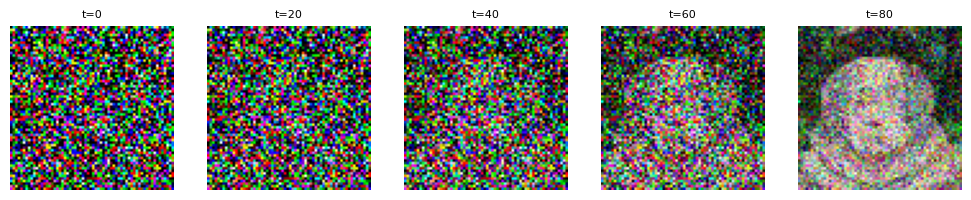

In [6]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Giả sử results có shape: (timesteps, B=1, C=3, H, W)
# Bỏ batch dim nếu B=1 → (100, 3, 64, 64)
results = results.squeeze(1).cpu()

# Chọn các bước theo t=0, 20, 40, 60, 80
selected_indices = list(range(0, results.shape[0], 20))
selected_images = [TF.to_pil_image(torch.clamp(results[i], 0, 1)) for i in selected_indices]

# Vẽ các ảnh đã chọn thành 1 hàng ngang
fig, axes = plt.subplots(1, len(selected_images), figsize=(len(selected_images) * 2, 2))
for i, ax in enumerate(axes):
    ax.imshow(selected_images[i])
    ax.axis('off')
    ax.set_title(f"t={selected_indices[i]}", fontsize=8)

plt.tight_layout()
plt.show()
